# Figure 7: Classifying TFs into Neg. Regs. vs. Rewirers

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import met_brewer
import pandas as pd
import numpy as np
import seaborn as sns
import sys
import upsetplot

from Bio.Seq import Seq
from scipy.stats import fisher_exact
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
import statsmodels.stats.multitest as smt

# import utils
sys.path.append("../")
sys.path.append("../data_loading")

import plotting
from plotting import PAPER_PRESET, PAPER_FONTSIZE, nice_boxplot, mimic_r_boxplot, annotate_pval

from data_loading import (load_annotated_TFiso1_collection,
                          load_developmental_tissue_expression_remapped,
                          load_gtex_remapped,
                          load_ref_vs_alt_isoforms_table,
                          load_condensate_data)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [3]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [4]:
np.random.seed(2023)

## functions

In [5]:
def calculate_tau(df):
    array = df.values
    
    ## will return NaN as tau for every row that has any NaNs
    array_max = np.max(array, axis=1)
    tmp = array.T / array_max
    tmp = 1 - tmp.T
    nonan_taus = np.sum(tmp, axis=1) / (array.shape[1])
    
    ## will ignore NaNs and compute on the rest of the values
    array_max = np.nanmax(array, axis=1)
    tmp = array.T / array_max
    tmp = 1 - tmp.T
    nan_taus = np.nansum(tmp, axis=1) / np.count_nonzero(~np.isnan(array), axis=1)
    
    
    return nonan_taus, nan_taus, array_max

In [6]:
rename_dev_stage = {'8 week post conception,embryo': '08',
'11 week post conception,late embryo': '11',
'embryo,7 week post conception': '07',
'infant': 'infant',
'10 week post conception,late embryo': '10',
'young adult': 'young adult',
'13 week post conception,late embryo': '13',
'16 week post conception,late embryo': '16',
'4 week post conception,embryo': '04',
'neonate': 'neonate',
'19 week post conception,late embryo': '19',
'9 week post conception,late embryo': '09',
'adolescent': 'adolescent',
'5 week post conception,embryo': '05',
'embryo,6 week post conception': '06',
'12 week post conception,late embryo': '12',
'18 week post conception,late embryo': '18',
'toddler': 'toddler',
'elderly': 'elderly',
'middle adult': 'adult',
'school age child': 'child'}

In [7]:
dn_pal = {"ref": sns.color_palette("Set2")[0],
       "similar": sns.color_palette("Set2")[0],
       "rewire": sns.color_palette("Set2")[2],
       "DN": sns.color_palette("Set2")[1],
       "NA": "lightgray",
       "likely": "darkgray",
          "combination": sns.color_palette("Set2")[5]}

## variables

In [8]:
joung_orf_f = "../../data/external/joung_files/Joung_ORF_lib.txt"
joung_data_f = "../../data/external/joung_files/Joung_ORF_scores.txt"
joung_cells_f = "../../data/external/joung_files/Figure3B_celltype_mapping.csv"

joung_down_map_batch_f = "../../data/external/joung_files/subsample_mapping_batch.txt"
joung_down_map_TF_f = "../../data/external/joung_files/subsample_mapping_TF.txt"
joung_down_map_louvain_f = "../../data/external/joung_files/subsample_mapping_louvain.txt"

## 1. import data

In [9]:
pairs = load_ref_vs_alt_isoforms_table()

# RORC-1 alt iso is causing an error - filter out here - there's no data for it?
pairs = pairs[pairs["clone_acc_alt"] != "RORC|1/6|05F11"]

pairs['ref_iso'] = pairs['clone_acc_ref'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])
pairs['alt_iso'] = pairs['clone_acc_alt'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])

In [10]:
joung_orf = pd.read_table(joung_orf_f)
joung_orf["Name"] = joung_orf["Name"].str.strip()

joung_data = pd.read_table(joung_data_f)
joung_data["Name"] = joung_data["TF ORF"].str.split("-", expand=True)[0].str.strip()

joung_cells = pd.read_table(joung_cells_f, sep=",")

joung_down_map_batch = pd.read_table(joung_down_map_batch_f, index_col=0)
print(len(joung_down_map_batch))
joung_down_map_TF = pd.read_table(joung_down_map_TF_f, index_col=0)
print(len(joung_down_map_TF))
joung_down_map_louvain = pd.read_table(joung_down_map_louvain_f, index_col=0)
print(len(joung_down_map_louvain))

joung_down_map = joung_down_map_batch.join(joung_down_map_TF).join(joung_down_map_louvain)
print(len(joung_down_map))

671453
671453
671453
671453


In [11]:
df_gtex, metadata_gtex, genes_gtex = load_gtex_remapped()

exclusion_list_gtex = {'Cells - Leukemia cell line (CML)',
                       'Cells - EBV-transformed lymphocytes',
                       'Cells - Cultured fibroblasts'}

df_gtex = df_gtex.loc[:, ~df_gtex.columns.map(metadata_gtex['body_site']).isin(exclusion_list_gtex)]
metadata_gtex = metadata_gtex.loc[~metadata_gtex['body_site'].isin(exclusion_list_gtex), :]

means_gtex = df_gtex.groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1).mean()

reading from cache


In [12]:
metadata_gtex_dummy = pd.read_table("../../data/processed/metadata_gtex_dummy.csv", sep=",", index_col=0)

In [13]:
df_dev, metadata_dev, genes_dev = load_developmental_tissue_expression_remapped()

rename_dev_stage = {'8 week post conception,embryo': '08',
'11 week post conception,late embryo': '11',
'embryo,7 week post conception': '07',
'infant': 'infant',
'10 week post conception,late embryo': '10',
'young adult': 'young adult',
'13 week post conception,late embryo': '13',
'16 week post conception,late embryo': '16',
'4 week post conception,embryo': '04',
'neonate': 'neonate',
'19 week post conception,late embryo': '19',
'9 week post conception,late embryo': '09',
'adolescent': 'adolescent',
'5 week post conception,embryo': '05',
'embryo,6 week post conception': '06',
'12 week post conception,late embryo': '12',
'18 week post conception,late embryo': '18',
'toddler': 'toddler',
'elderly': 'elderly',
'middle adult': 'adult',
'school age child': 'child'}

metadata_dev['dev_stage'] = metadata_dev['Developmental_Stage'].map(rename_dev_stage)
means_dev = (df_dev.groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']), axis=1)
           .mean())

reading from cache


## 2. categorize based on assay data

### M1H

In [14]:
def m1h_cat(row):
    
    # ref is activator
    if row.activation_ref >= 1:
        if row.activation_fold_change_log2 <= -1 and row.activation_alt <= 1 and row.activation_alt >= -1:
            return "activation loss"
        elif not pd.isnull(row.activation_fold_change_log2):
            
            # only consider iso to be rewired if foldchange > 2x
            if np.abs(row.activation_fold_change_log2) >= 1:
                return "rewire"
            else:
                return "similar"

        else:
            return "NA"
    
    # ref is repressor
    elif row.activation_ref <= -1:
        if row.activation_fold_change_log2 >= 1 and row.activation_alt <= 1 and row.activation_alt >= -1:
            return "repression loss"
        elif not pd.isnull(row.activation_fold_change_log2):
            
            # only consider iso to be rewired if foldchange > 2x
            if np.abs(row.activation_fold_change_log2) >= 1:
                return "rewire"
            else:
                return "similar"
        else:
            return "NA"
        
    # no ref data so can't make conclusions
    elif pd.isnull(row.activation_ref):
        return "NA"
    
    # ref is middling so can be GoF
    else:
        if row.activation_fold_change_log2 >= 1:
            return "activation GoF"
        elif row.activation_fold_change_log2 <= -1:
            return "repression GoF"
        
        # if both isoforms are middling, consider similar
        elif not pd.isnull(row.activation_fold_change_log2):
            return "similar"
        
        else:
            return "NA"
        
pairs["m1h_cat"] = pairs.apply(m1h_cat, axis=1)
pairs.m1h_cat.value_counts()

similar            194
NA                 119
rewire              61
activation loss     39
repression GoF      16
activation GoF       9
repression loss      8
Name: m1h_cat, dtype: int64

### Y1H

In [15]:
def y1h_cat(row):
    if row.n_positive_PDI_ref_filtered > 0:
        if row.n_positive_PDI_alt_filtered == 0:
            return "PDI loss"
        elif row.n_shared_PDI == row.n_PDI_successfully_tested_in_ref_and_alt:
            return "no PDI change"
        elif pd.isnull(row.n_positive_PDI_alt_filtered):
            return "NA"
        else:
            return "PDI rewire"
    elif row.n_positive_PDI_ref_filtered == 0:
        if row.n_positive_PDI_alt_filtered > 0:
            return "PDI gain"
        else:
            return "NA"
    else:
        return "NA"
    
pairs["y1h_cat"] = pairs.apply(y1h_cat, axis=1)
pairs.y1h_cat.value_counts()

NA               374
PDI loss          28
PDI rewire        27
PDI gain           9
no PDI change      8
Name: y1h_cat, dtype: int64

### Y2H

In [16]:
def y2h_cat(row):
    if row.dimer_ppi == "loses all" or row.tf_cofactor_ppi == "loses all" or row.tf_signalling_ppi == "loses all":
        n = []
        if row.dimer_ppi == "loses all":
            n.append("dimer")
        if row.tf_cofactor_ppi == "loses all":
            n.append("cofactor")
        if row.tf_signalling_ppi == "loses all":
            n.append("signalling")
        s = ",".join(n)
        s = "PPI loss: %s" % s
        return s
    
    elif row.n_positive_PPI_ref > 0 and row.n_positive_PPI_alt == 0:
        return "PPI loss: all"
    
    elif row.dimer_ppi == "retains all" and row.tf_cofactor_ppi == "retains all" and row.tf_signalling_ppi == "retains all":
        if row.other_than_dimer_ppi == "retains all":
            return "no PPI change (all PPIs)"
        else:
            return "no PPI change (important PPIs)"
    
    elif pd.isnull(row.dimer_ppi) and pd.isnull(row.tf_cofactor_ppi) and pd.isnull(row.tf_signalling_ppi) and pd.isnull(row.other_than_dimer_ppi) and pd.isnull(row.tf_tf_ppi):
        return "NA"
    
    else:
        
        # all PPIs retained but some above categories null so missed in if statements
        if row.PPI_jaccard == 1:
            return "no PPI change (all PPIs)"
        else:
            return "PPI rewire"
    
pairs["y2h_cat"] = pairs.apply(y2h_cat, axis=1)
pairs.y2h_cat.value_counts()

NA                                296
PPI loss: all                      53
PPI rewire                         43
no PPI change (all PPIs)           31
PPI loss: cofactor,signalling       7
PPI loss: signalling                5
PPI loss: cofactor                  5
no PPI change (important PPIs)      3
PPI loss: dimer                     3
Name: y2h_cat, dtype: int64

## localization

In [17]:
con_pairs, con_df = load_condensate_data()

In [18]:
pairs = pairs.merge(con_pairs[["gene_symbol", "clone_acc_ref", "clone_acc_alt",
                               'condensates_observed_HEK_ref',
       'condensates_observed_U2OS_ref', 'HEK_Condensate_ref',
       'U2OS_Condensate_ref', 'localization_HEK_ref', 'localization_U2OS_ref',
       'condensates_observed_HEK_alt', 'condensates_observed_U2OS_alt',
       'HEK_Condensate_alt', 'U2OS_Condensate_alt', 'localization_HEK_alt',
       'localization_U2OS_alt', 'condensate_cat_HEK', 'condensate_cat_U2OS',
       'condensate_cat_merged_HEK', 'condensate_cat_merged_U2OS',
       'condensate_cat_only_HEK', 'condensate_cat_only_U2OS',
       'localization_cat_HEK', 'localization_cat_U2OS',
       'condensate_cat_only_detailed_HEK', 'condensate_cat_only_detailed_U2OS',
       'condensate_or_loc_change_HEK', 'condensate_or_loc_change_U2OS',
       'combined_cat_HEK', 'combined_cat_U2OS',
       'condensate_or_loc_change_both', 'condensate_cat_detailed_HEK',
       'condensate_cat_detailed_U2OS']], how="left", on=["gene_symbol", "clone_acc_ref", "clone_acc_alt"])

In [19]:
pairs.localization_HEK_ref.value_counts()

both         66
nucleus      51
cytoplasm    12
Name: localization_HEK_ref, dtype: int64

In [20]:
def loc_cat_HEK(row):
    if row.localization_HEK_ref == "nucleus" or row.localization_HEK_ref == "both":
        if row.localization_HEK_alt == "cytoplasm":
            return "localization loss"
        elif row.localization_HEK_alt == "nucleus" or row.localization_HEK_alt == "both":
            return "no localization change"
        elif not pd.isnull(row.localization_HEK_alt):
            return "localization change"
        else:
            return "NA"
        
    # if ref is exclusively cytoplasm, call loc change but not loc loss
    elif row.localization_HEK_ref == "cytoplasm":
        if row.localization_HEK_alt == "cytoplasm":
            return "no localization change"
        elif row.localization_HEK_alt == "nucleus" or row.localization_HEK_alt == "both":
            return "localization change"
        elif not pd.isnull(row.localization_HEK_alt):
            return "localization change"
        else:
            return "NA"
    
    else:
        return "NA"
    
def loc_cat_U2OS(row):
    if row.localization_U2OS_ref == "nucleus" or row.localization_U2OS_ref == "both":
        if row.localization_U2OS_alt == "cytoplasm":
            return "localization loss"
        elif row.localization_U2OS_alt == "nucleus" or row.localization_U2OS_alt == "both":
            return "no localization change"
        elif not pd.isnull(row.localization_U2OS_alt):
            return "localization change"
        else:
            return "NA"
        
    # if ref is exclusively cytoplasm, call loc change but not loc loss
    elif row.localization_U2OS_ref == "cytoplasm":
        if row.localization_HEK_alt == "cytoplasm":
            return "no localization change"
        elif row.localization_U2OS_alt == "nucleus" or row.localization_U2OS_alt == "both":
            return "localization change"
        elif not pd.isnull(row.localization_U2OS_alt):
            return "localization change"
        else:
            return "NA"
    
    else:
        return "NA"
        
def loc_cat(row):
    if row.loc_cat_HEK == "localization loss" or row.loc_cat_U2OS == "localization loss":
        return "localization loss"
    elif row.loc_cat_HEK == "localization change" or row.loc_cat_U2OS == "localization change":
        return "localization change"
    elif row.loc_cat_HEK == "no localization change" and row.loc_cat_U2OS == "no localization change":
        return "no localization change"
    else:
        return "NA"
    
pairs["loc_cat_HEK"] = pairs.apply(loc_cat_HEK, axis=1)
pairs["loc_cat_U2OS"] = pairs.apply(loc_cat_U2OS, axis=1)
pairs["loc_cat"] = pairs.apply(loc_cat, axis=1)
pairs.loc_cat.value_counts()

NA                        317
no localization change    106
localization loss          15
localization change         8
Name: loc_cat, dtype: int64

## 3. categorize negative regulators
include any whose DBD loss is >= 10%

In [21]:
def dn_cat(row, dbd_thresh=10):
    
    # if activity loss
    if "loss" in row.m1h_cat:
        if "loss" in row.y1h_cat and "loss: all" in row.y2h_cat:
            return "likely nf"
        else:
            if row.y1h_cat == "NA" and row.y2h_cat == "NA":
                return "NA"
            else:
                n = ["activ"]
                if "loss" in row.y1h_cat:
                    n.append("PDIs")
                if "loss" in row.y2h_cat:
                    n.append("PPIs")
                if row.dbd_pct_lost >= dbd_thresh:
                    n.append("DBD loss")
                s = ",".join(n)
                s = "DN (%s)" % s
                return s
    
    # otherwise, if no evidence of m1h activity
    elif row.activation_alt <= 1 and row.activation_alt >= -1:
        if "loss" in row.y1h_cat and "loss: all" in row.y2h_cat:
            return "likely nf"
        else:
            if row.y1h_cat == "NA" and row.y2h_cat == "NA":
                return "NA"
            else:
                n = []
                if "loss" in row.y1h_cat:
                    n.append("PDIs")
                if "loss" in row.y2h_cat:
                    n.append("PPIs")
                if row.dbd_pct_lost >= dbd_thresh:
                    n.append("DBD loss")
                
                if len(n) > 0:
                    s = ",".join(n)
                    s = "DN (%s)" % s
                    
                else:
                    
                    # if m1h category is similar, and y1h/y2h are also no change, consider similar
                    if row.m1h_cat == "similar":
                        if row.y1h_cat == "no PDI change" and "no PPI change" in row.y2h_cat:
                            s = "similar"
                        elif row.y1h_cat == "no PDI change" and row.y2h_cat == "NA":
                            s = "similar"
                        elif row.y1h_cat == "NA" and "no PPI change" in row.y2h_cat:
                            s = "similar"
                        else:
                            s = "rewire"
                    else:
                        s = "rewire"
                
                return s
    
    # otherwise, if no m1h data
    elif pd.isnull(row.activation_alt):
        if "loss" in row.y1h_cat and "loss: all" in row.y2h_cat:
            return "NA"
        else:
            if row.y1h_cat == "NA" and row.y2h_cat == "NA":
                return "NA"
            elif row.y1h_cat != "NA" and row.y2h_cat != "NA":
                n = []
                if "loss" in row.y1h_cat:
                    n.append("PDIs")
                if "loss" in row.y2h_cat:
                    n.append("PPIs")
                if row.dbd_pct_lost >= dbd_thresh:
                    n.append("DBD loss")
                
                if len(n) > 0:
                    s = ",".join(n)
                    s = "DN (%s)" % s
                else:
                    
                    # if both y1h and y2h are similar, consider similar
                    if row.y1h_cat == "no PDI change" and "no PPI change" in row.y2h_cat:
                        s = "similar"
                    else:
                        s = "rewire"
                
                return s
            
            else:
                return "NA"
            
    # otherwise, if evidence of m1h functionality
    else:
        if row.y1h_cat == "NA" and row.y2h_cat == "NA":
            return "NA"
        else:
            n = []
            if "loss" in row.y1h_cat:
                n.append("PDIs")
            if "loss" in row.y2h_cat:
                n.append("PPIs")
            if row.dbd_pct_lost >= dbd_thresh:
                n.append("DBD loss")

            if len(n) > 0:
                s = ",".join(n)
                s = "DN (%s)" % s
            else:
                
                # if m1h category is similar, and y1h/y2h are also no change, consider similar
                if row.m1h_cat == "similar":
                    if row.y1h_cat == "no PDI change" and "no PPI change" in row.y2h_cat:
                        s = "similar"
                    elif row.y1h_cat == "no PDI change" and row.y2h_cat == "NA":
                        s = "similar"
                    elif row.y1h_cat == "NA" and "no PPI change" in row.y2h_cat:
                        s = "similar"
                    else:
                        s = "rewire"
                else:
                    s = "rewire"

            return s
            
pairs["dn_cat"] = pairs.apply(dn_cat, axis=1)
pairs.dn_cat.value_counts()

NA                               273
rewire                            58
DN (PPIs)                         32
DN (PPIs,DBD loss)                19
similar                           16
DN (DBD loss)                     11
DN (PDIs,DBD loss)                 9
DN (PDIs)                          5
DN (activ,PPIs)                    4
DN (activ)                         4
DN (PDIs,PPIs,DBD loss)            3
DN (activ,DBD loss)                2
DN (activ,PPIs,DBD loss)           2
DN (activ,PDIs,DBD loss)           2
DN (PDIs,PPIs)                     2
likely nf                          1
DN (activ,PDIs)                    1
DN (activ,PDIs,PPIs,DBD loss)      1
DN (activ,PDIs,PPIs)               1
Name: dn_cat, dtype: int64

In [22]:
# now update anything based on localization calls
# but only if we were initially able to categorize it as DN/sim/rw
# (NAs stay NAs as loc is not evidence of function on its own)
def dn_loc(row):
    if row.dn_cat == "NA":
        return "NA"
    elif row.dn_cat == "likely nf":
        return "likely nf"
    else:
        
        # loc loss = DN
        if row.loc_cat == "localization loss":
            if row.dn_cat == "rewire" or row.dn_cat == "similar":
                return "DN (loc loss)"
            else:
                s = row.dn_cat[:-1]
                s += ", loc loss)"
                return s
        
        # loc change = rw
        elif row.loc_cat == "localization change":
            if row.dn_cat == "rewire" or row.dn_cat == "similar":
                return "rewire"
            else:
                return row.dn_cat
        
        else:
            return row.dn_cat
        
pairs["dn_cat_plus_loc"] = pairs.apply(dn_loc, axis=1)
pairs["dn_cat_plus_loc"].value_counts()

NA                               273
rewire                            54
DN (PPIs)                         32
DN (PPIs,DBD loss)                19
similar                           15
DN (DBD loss)                      9
DN (PDIs,DBD loss)                 8
DN (loc loss)                      5
DN (PDIs)                          5
DN (activ,PPIs)                    4
DN (activ)                         3
DN (PDIs,PPIs,DBD loss)            3
DN (activ,DBD loss)                2
DN (activ,PPIs,DBD loss)           2
DN (activ,PDIs,DBD loss)           2
DN (PDIs,PPIs, loc loss)           2
DN (DBD loss, loc loss)            2
likely nf                          1
DN (activ,PDIs,PPIs,DBD loss)      1
DN (activ,PDIs,PPIs)               1
DN (PDIs,DBD loss, loc loss)       1
DN (activ, loc loss)               1
DN (activ,PDIs)                    1
Name: dn_cat_plus_loc, dtype: int64

In [23]:
pairs["dn_cat"] = pairs["dn_cat_plus_loc"]

In [208]:
pairs[pairs["dn_cat"] == "DN (loc loss)"][["gene_symbol", "clone_acc_ref", "clone_acc_alt",
                                           "m1h_cat", "y1h_cat", "y2h_cat", "dbd_pct_lost", "loc_cat_HEK", 
                                           "loc_cat_U2OS", "loc_cat", "dn_cat"]]

,gene_symbol,clone_acc_ref,clone_acc_alt,m1h_cat,y1h_cat,y2h_cat,dbd_pct_lost,loc_cat_HEK,loc_cat_U2OS,loc_cat,dn_cat
131,TFAP2A,TFAP2A|2/4|09G07,TFAP2A|3/4|09D06,similar,no PDI change,NA,0.0,localization loss,no localization change,localization loss,DN (loc loss)
274,MAX,MAX|1/6|08G02,MAX|3/6|08E02,rewire,PDI rewire,NA,0.0,no localization change,localization loss,localization loss,DN (loc loss)
355,TCF4,TCF4|1/9|07E01,TCF4|4/9|07G02,similar,PDI rewire,no PPI change (important PPIs),0.0,no localization change,localization loss,localization loss,DN (loc loss)
357,TCF4,TCF4|1/9|07E01,TCF4|6/9|07H03,rewire,NA,PPI rewire,0.0,localization loss,no localization change,localization loss,DN (loc loss)
359,TCF4,TCF4|1/9|07E01,TCF4|8/9|07A05,similar,PDI rewire,PPI rewire,0.0,localization loss,no localization change,localization loss,DN (loc loss)


In [25]:
# double check that rewirers aren't all the same across axes

In [26]:
to_plot = pairs[pairs["dn_cat"].isin(["rewire", "similar"])][["gene_symbol", "clone_acc_ref", "clone_acc_alt",
                                              "PPI_jaccard", "PDI_jaccard", "dbd_pct_lost",
                                              "activation_fold_change_log2", "loc_cat", "dn_cat"]]

# make cols that are easier to visualize on plot
to_plot["fc_abs_activ"] = 2**-np.abs(to_plot["activation_fold_change_log2"])
to_plot["1m_dbd_pct"] = (100-to_plot["dbd_pct_lost"])/100

# comment this out if we delete loc stuff
def loc_quant(row):
    if row.loc_cat == "NA":
        return np.nan
    elif row.loc_cat == "localization loss":
        return 0
    elif row.loc_cat == "no localization change":
        return 1
    else:
        return 0.5
to_plot["loc_quant"] = to_plot.apply(loc_quant, axis=1)

In [27]:
isos = to_plot.copy()
isos = isos.sort_values(by="dn_cat")
isos = isos.reset_index().reset_index()

theoretical_iso = {"level_0": [isos.level_0.max()+1], "index": [0], "gene_symbol": ["theoretical"],
                   "clone_acc_ref": ["theoretical"], "clone_acc_alt": ["theoretical"],
                   "PPI_jaccard": [1.0], "PDI_jaccard": [1.0], "dbd_pct_lost": [0.0],
                   "activation_fold_change_log2": [np.log2(1)], "fc_abs_activ": [1.0],
                   "1m_dbd_pct": [1.0], "loc_cat": ["no localization change"], "loc_quant": [1.0], 
                   "dn_cat": ["theoretical"]}

isos = isos.append(pd.DataFrame.from_dict(theoretical_iso))
isos

,level_0,index,gene_symbol,clone_acc_ref,clone_acc_alt,PPI_jaccard,PDI_jaccard,dbd_pct_lost,activation_fold_change_log2,loc_cat,dn_cat,fc_abs_activ,1m_dbd_pct,loc_quant
0,0,0,ZBTB18,ZBTB18|1/2|04E08,ZBTB18|2/2|12E05,0.750000,0.000000,0.000000,0.503414,no localization change,rewire,0.705435,1.000000,1.0
1,1,170,HMBOX1,HMBOX1|2/5|03C07,HMBOX1|3/5|03E06,0.166667,NaN,0.000000,-0.046974,localization change,rewire,0.967964,1.000000,0.5
2,2,208,ZNF438,ZNF438|1/2|09H05,ZNF438|2/2|09E04,0.160000,0.000000,0.000000,0.752061,NA,rewire,0.593755,1.000000,NaN
3,3,438,ZIC3,ZIC3|2/3|12F04,ZIC3|3/3|09C04,NaN,0.705882,1.197605,-1.470214,no localization change,rewire,0.360929,0.988024,1.0
4,4,217,ZNF143,ZNF143|1/3|09D07,ZNF143|3/3|09A08,0.666667,1.000000,0.000000,-0.300432,NA,rewire,0.812009,1.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,65,85,RBPJ,RBPJ|2/4|07B11,RBPJ|3/4|07D11,1.000000,NaN,0.000000,0.707642,NA,similar,0.612320,1.000000,NaN
66,66,290,SMAD3,SMAD3|1/4|06A07,SMAD3|2/4|06G07,1.000000,NaN,0.000000,0.246502,NA,similar,0.842938,1.000000,NaN
67,67,349,ZNF397,ZNF397|2/5|11C06,ZNF397|4/5|08G07,1.000000,NaN,NaN,-0.563765,NA,similar,0.676534,NaN,NaN
68,68,147,ZNF212,ZNF212|1/2|12D01,ZNF212|2/2|03E09,1.000000,NaN,0.000000,-0.245366,NA,similar,0.843602,1.000000,NaN


In [28]:
columns_to_plot = ["level_0", "PPI_jaccard", "PDI_jaccard", "fc_abs_activ", "1m_dbd_pct", "loc_quant"]
column_titles = ["", "PPI\n(jaccard)", "PDI\n(jaccard)",
                 "activ.\n(% of ref.)", "DBD\n(% of ref.)", "∆ localization"]

# separate into similar v rewires
isos_sim = isos[isos["dn_cat"].isin(["similar", "theoretical"])]
isos_rw = isos[isos["dn_cat"].isin(["rewire"])]

colors = sns.color_palette("husl", n_colors=len(isos_rw))

### similar first

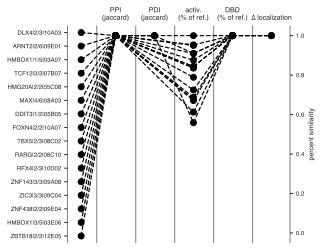

In [29]:
# Creating the figure and axes (subplots) aligned in a single row without shared y-axis
gs_kw = dict(width_ratios=[0.75, 1, 1, 1, 1, 1])
fig, axs = plt.subplots(1, 6, sharey=False, gridspec_kw=gs_kw)
fig.set_size_inches(w=4, h=4)
df = isos_sim

# Adjusting the space between subplots for better alignment of lines
fig.subplots_adjust(wspace=0.05)

# zorder of axis labels
plt.rcParams["axes.axisbelow"] = False

# Re-plotting each column in a separate subplot
for i, col in enumerate(columns_to_plot):
    axs[i].clear()  # Clear previous axes to avoid duplication
    axs[i].set_title(column_titles[i])  # Setting the title of the subplot to the column name
    axs[i].set_xticks([])  # Hide x-axis labels

    # Setting different limits for y-axis based on column data
    axs[i].set_ylim(np.nanmin(df[col]) - 0.1, np.nanmax(df[col]) + 0.1)
    
    j = 0
    black_js = []
    for name, cat in zip(df['clone_acc_alt'], df['dn_cat']):
        if name == "theoretical":
            color = "black"
            black_js.append(j)
        elif cat == "similar":
            color = "black"
            black_js.append(j)
        else:
            color = colors[j]
        
        # Mark the value with a dot
        axs[i].plot(0, df[col].iloc[j], color=color, marker='o', 
                    markersize=6)
        j += 1
    
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)
    
    if i == 0:
        axs[i].spines['right'].set_visible(False)
    elif i == 5:
        axs[i].yaxis.tick_right()
        axs[i].yaxis.set_label_position("right")
        axs[i].set_ylabel("percent similarity")
    else:
        axs[i].spines['right'].set_visible(False)
        axs[i].yaxis.set_tick_params(labelleft=False)
        axs[i].set_yticks([])

# Remove previous lines
fig.lines = []

# set axis limits
tickpos = list(df["level_0"])
axs[0].set_ylim((tickpos[0]-0.5), (tickpos[-1]+0.5))
axs[1].set_ylim((-0.05, 1.05))
axs[2].set_ylim((-0.05, 1.05))
axs[3].set_ylim((-0.05, 1.05))
axs[4].set_ylim((-0.05, 1.05))
axs[5].set_ylim((-0.05, 1.05))


# Data preparation for plotting
data_lines = []
for _, row in df.iterrows():
    data_lines.append([row[columns_to_plot[0]], row[columns_to_plot[1]], 
                       row[columns_to_plot[2]], row[columns_to_plot[3]],
                       row[columns_to_plot[4]], row[columns_to_plot[5]]])

# Re-connecting dots across subplots with lines
for j, data_line in enumerate(data_lines):
    if j in black_js:
        color = "black"
    else:
        color = colors[j]
        
    skip_flag = False
    
    # Adding lines between subplots; adjusting coordinates for subplot borders
    for k in range(len(axs)-1):
        # We use figure coordinates to draw lines between subplots
        transFigure = fig.transFigure.inverted()
        
        
        if not skip_flag:
            pt1_k = k
            pt2_k = k+1
            pt1 = data_line[pt1_k]
            pt2 = data_line[pt2_k]
        
        # if we prev skipped due to na, keep the same pt1 and use current pt2
        else:
            pt1_k = k-1
            pt2_k = k+1
            pt1 = data_line[pt1_k]
            pt2 = data_line[pt2_k]
            
        if np.isnan(pt2):
            #print("skip flag true")
            skip_flag = True
            continue
        else:
            skip_flag = False
        
        #print("pt1: %s | pt2: %s | ax1: %s | ax2: %s" % (pt1, pt2, pt1_k, pt2_k))
        
        # Get coordinates of the points in figure coordinate system
        coord1 = transFigure.transform(axs[pt1_k].transData.transform([0, pt1]))
        coord2 = transFigure.transform(axs[pt2_k].transData.transform([0, pt2]))

        # Calculate the space adjustment based on the subplot spacing
        #space_adjustment = 0.015 + 0.23 * k

        # Adding space adjustment to x-coordinate for accurate alignment
        line = plt.Line2D((coord1[0], coord2[0]), 
                          (coord1[1], coord2[1]), 
                          transform=fig.transFigure, color=color, linestyle="dashed")
        fig.add_artist(line)
        


# relabel ticks
ticklabels = list(isos["clone_acc_alt"])
axs[0].set_yticks(tickpos)
_ = axs[0].set_yticklabels(ticklabels)

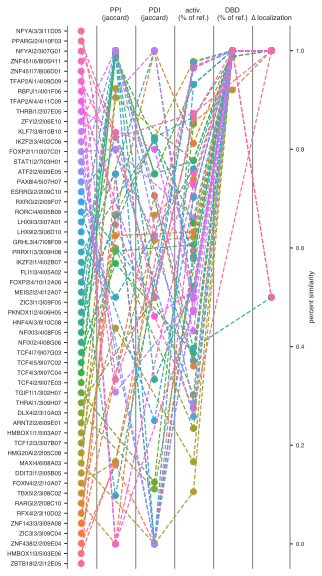

In [30]:
# Creating the figure and axes (subplots) aligned in a single row without shared y-axis
gs_kw = dict(width_ratios=[0.75, 1, 1, 1, 1, 1])
fig, axs = plt.subplots(1, 6, sharey=False, gridspec_kw=gs_kw)
fig.set_size_inches(w=4, h=10)
df = isos_rw

# Adjusting the space between subplots for better alignment of lines
fig.subplots_adjust(wspace=0.05)

# zorder of axis labels
plt.rcParams["axes.axisbelow"] = False

# Re-plotting each column in a separate subplot
for i, col in enumerate(columns_to_plot):
    axs[i].clear()  # Clear previous axes to avoid duplication
    axs[i].set_title(column_titles[i])  # Setting the title of the subplot to the column name
    axs[i].set_xticks([])  # Hide x-axis labels

    # Setting different limits for y-axis based on column data
    axs[i].set_ylim(np.nanmin(df[col]) - 0.1, np.nanmax(df[col]) + 0.1)
    
    j = 0
    black_js = []
    for name, cat in zip(df['clone_acc_alt'], df['dn_cat']):
        if name == "theoretical":
            color = "black"
            black_js.append(j)
        elif cat == "similar":
            color = "black"
            black_js.append(j)
        else:
            color = colors[j]
        
        # Mark the value with a dot
        axs[i].plot(0, df[col].iloc[j], color=color, marker='o', 
                    markersize=6)
        j += 1
    
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)
    
    if i == 0:
        axs[i].spines['right'].set_visible(False)
    elif i == 5:
        axs[i].yaxis.tick_right()
        axs[i].yaxis.set_label_position("right")
        axs[i].set_ylabel("percent similarity")
    else:
        axs[i].spines['right'].set_visible(False)
        axs[i].yaxis.set_tick_params(labelleft=False)
        axs[i].set_yticks([])

# Remove previous lines
fig.lines = []

# set axis limits
tickpos = list(df["level_0"])
axs[0].set_ylim((tickpos[0]-0.5), (tickpos[-1]+0.5))
axs[1].set_ylim((-0.05, 1.05))
axs[2].set_ylim((-0.05, 1.05))
axs[3].set_ylim((-0.05, 1.05))
axs[4].set_ylim((-0.05, 1.05))
axs[5].set_ylim((-0.05, 1.05))


# Data preparation for plotting
data_lines = []
for _, row in df.iterrows():
    data_lines.append([row[columns_to_plot[0]], row[columns_to_plot[1]], 
                       row[columns_to_plot[2]], row[columns_to_plot[3]],
                       row[columns_to_plot[4]], row[columns_to_plot[5]]])

# Re-connecting dots across subplots with lines
for j, data_line in enumerate(data_lines):
    if j in black_js:
        color = "black"
    else:
        color = colors[j]
        
    skip_flag = False
    
    # Adding lines between subplots; adjusting coordinates for subplot borders
    for k in range(len(axs)-1):
        # We use figure coordinates to draw lines between subplots
        transFigure = fig.transFigure.inverted()
        
        
        if not skip_flag:
            pt1_k = k
            pt2_k = k+1
            pt1 = data_line[pt1_k]
            pt2 = data_line[pt2_k]
        
        # if we prev skipped due to na, keep the same pt1 and use current pt2
        else:
            pt1_k = k-1
            pt2_k = k+1
            pt1 = data_line[pt1_k]
            pt2 = data_line[pt2_k]
            
        if np.isnan(pt2):
            #print("skip flag true")
            skip_flag = True
            continue
        else:
            skip_flag = False
        
        #print("pt1: %s | pt2: %s | ax1: %s | ax2: %s" % (pt1, pt2, pt1_k, pt2_k))
        
        # Get coordinates of the points in figure coordinate system
        coord1 = transFigure.transform(axs[pt1_k].transData.transform([0, pt1]))
        coord2 = transFigure.transform(axs[pt2_k].transData.transform([0, pt2]))

        # Calculate the space adjustment based on the subplot spacing
        #space_adjustment = 0.015 + 0.23 * k

        # Adding space adjustment to x-coordinate for accurate alignment
        line = plt.Line2D((coord1[0], coord2[0]), 
                          (coord1[1], coord2[1]), 
                          transform=fig.transFigure, color=color, linestyle="dashed")
        fig.add_artist(line)
        


# relabel ticks
ticklabels = list(isos["clone_acc_alt"])
axs[0].set_yticks(tickpos)
_ = axs[0].set_yticklabels(ticklabels)

## 4. summary plots of DN categorization

In [31]:
pairs["dn_short"] = pairs["dn_cat"].str.split(" ", expand=True)[0]
pairs.dn_short.value_counts()

NA         273
DN         103
rewire      54
similar     15
likely       1
Name: dn_short, dtype: int64

In [32]:
pairs[pairs["dn_short"] == "likely"]

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,...,combined_cat_U2OS,condensate_or_loc_change_both,condensate_cat_detailed_HEK,condensate_cat_detailed_U2OS,loc_cat_HEK,loc_cat_U2OS,loc_cat,dn_cat,dn_cat_plus_loc,dn_short
68,PPARG,ENSG00000132170,Nuclear receptor,True,PPARG|1/4|10G02,PPARG|3/4|01H02,ENST00000287820,NaN,False,True,...,Same localization and condensate formation,NaN,CC -> BOTH,CC -> BOTH,localization change,no localization change,localization change,likely nf,likely nf,likely


In [33]:
pairs[pairs["dn_cat"] == "DN (loc loss)"]

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,...,combined_cat_U2OS,condensate_or_loc_change_both,condensate_cat_detailed_HEK,condensate_cat_detailed_U2OS,loc_cat_HEK,loc_cat_U2OS,loc_cat,dn_cat,dn_cat_plus_loc,dn_short
131,TFAP2A,ENSG00000137203,AP-2,True,TFAP2A|2/4|09G07,TFAP2A|3/4|09D06,ENST00000379613|ENST00000482890,ENST00000319516,False,False,...,Same localization and condensate formation,NaN,BOTH -> CC,BOTH -> BOTH,localization loss,no localization change,localization loss,DN (loc loss),DN (loc loss),DN
274,MAX,ENSG00000125952,bHLH,True,MAX|1/6|08G02,MAX|3/6|08E02,ENST00000358664,ENST00000284165,False,False,...,Difference in localization,Difference,None -> CC,BOTH -> CC,no localization change,localization loss,localization loss,DN (loc loss),DN (loc loss),DN
355,TCF4,ENSG00000196628,bHLH,True,TCF4|1/9|07E01,TCF4|4/9|07G02,ENST00000354452|ENST00000629387,NaN,False,True,...,Difference in localization,Difference,NC -> CC,NC -> CC,no localization change,localization loss,localization loss,DN (loc loss),DN (loc loss),DN
357,TCF4,ENSG00000196628,bHLH,True,TCF4|1/9|07E01,TCF4|6/9|07H03,ENST00000354452|ENST00000629387,ENST00000457482,False,False,...,Difference in localization,Difference,NC -> CC,NC -> CC,localization loss,no localization change,localization loss,DN (loc loss),DN (loc loss),DN
359,TCF4,ENSG00000196628,bHLH,True,TCF4|1/9|07E01,TCF4|8/9|07A05,ENST00000354452|ENST00000629387,ENST00000561831,False,False,...,Difference in localization,Difference,NC -> CC,NC -> CC,localization loss,no localization change,localization loss,DN (loc loss),DN (loc loss),DN


In [34]:
pairs[pairs["gene_symbol"] == "FOXP2"][["gene_symbol", "clone_acc_alt", "clone_acc_ref",
                                        "m1h_cat", "y1h_cat", "y2h_cat", "loc_cat", "dn_cat_plus_loc"]]

,gene_symbol,clone_acc_alt,clone_acc_ref,m1h_cat,y1h_cat,y2h_cat,loc_cat,dn_cat_plus_loc
148,FOXP2,FOXP2|1/10|07C01,FOXP2|2/10|07B01,similar,NA,PPI rewire,no localization change,rewire
149,FOXP2,FOXP2|4/10|12A06,FOXP2|2/10|07B01,rewire,NA,PPI rewire,no localization change,rewire
150,FOXP2,FOXP2|6/10|06F12,FOXP2|2/10|07B01,activation loss,NA,NA,localization loss,NA
151,FOXP2,FOXP2|7/10|06G10,FOXP2|2/10|07B01,NA,NA,PPI loss: signalling,localization loss,NA
152,FOXP2,FOXP2|10/10|06A10,FOXP2|2/10|07B01,rewire,NA,PPI loss: all,no localization change,"DN (PPIs,DBD loss)"


In [35]:
def mech_bool(row, mech_col):
    if "DN" in row.dn_cat:
        if mech_col in row.dn_cat:
            return True
        else:
            return False
    else:
        return np.nan
    
pairs["dn_ppi"] = pairs.apply(mech_bool, mech_col="PPIs", axis=1)
pairs["dn_pdi"] = pairs.apply(mech_bool, mech_col="PDIs", axis=1)
pairs["dn_activ"] = pairs.apply(mech_bool, mech_col="activ", axis=1)
pairs["dn_dbd"] = pairs.apply(mech_bool, mech_col="DBD loss", axis=1)
pairs["dn_loc"] = pairs.apply(mech_bool, mech_col="loc loss", axis=1)
pairs[pairs["dn_short"] == "DN"].sample(5)

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,...,loc_cat_U2OS,loc_cat,dn_cat,dn_cat_plus_loc,dn_short,dn_ppi,dn_pdi,dn_activ,dn_dbd,dn_loc
431,PKNOX1,ENSG00000160199,Homeodomain,False,PKNOX1|1/4|11H11,PKNOX1|3/4|06H03,ENST00000291547,ENST00000432907,False,False,...,no localization change,no localization change,DN (PPIs),DN (PPIs),DN,True,False,False,False,False
47,ATF2,ENSG00000115966,bZIP,True,ATF2|1/6|12H04,ATF2|3/6|09C05,ENST00000264110|ENST00000392544,ENST00000345739|ENST00000409635,False,False,...,no localization change,no localization change,DN (PPIs),DN (PPIs),DN,True,False,False,False,False
342,MEOX1,ENSG00000005102,Homeodomain,False,MEOX1|1/3|08C05,MEOX1|3/3|08G03,ENST00000318579,NaN,False,True,...,no localization change,no localization change,"DN (activ,PDIs,PPIs,DBD loss)","DN (activ,PDIs,PPIs,DBD loss)",DN,True,True,True,True,False
5,GRHL3,ENSG00000158055,Grainyhead,True,GRHL3|3/7|08G09,GRHL3|1/7|08E10,ENST00000361548,ENST00000350501,False,False,...,no localization change,no localization change,DN (PPIs),DN (PPIs),DN,True,False,False,False,False
228,ZBTB44,ENSG00000196323,C2H2 ZF,False,ZBTB44|1/9|12B06,ZBTB44|6/9|12H02,ENST00000357899|ENST00000397753,NaN,False,True,...,localization loss,localization loss,"DN (DBD loss, loc loss)","DN (DBD loss, loc loss)",DN,False,False,False,True,True


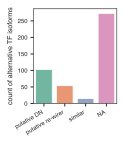

In [36]:
fig = plt.figure(figsize=(1.5, 1.75))

ax = sns.countplot(data=pairs, x="dn_short", palette=sns.color_palette("Set2"),
                   order=["DN", "rewire", "similar", "NA"])
ax.set_xticklabels(["putative DN", "putative re-wirer", "similar", "NA"], ha="right", va="top", rotation=30)
ax.set_xlabel("")
ax.set_ylabel("count of alternative TF isoforms")

fig.savefig("../../figures/fig7/DN_countplot.pdf", dpi="figure", bbox_inches="tight")

In [37]:
from upsetplot import plot

98


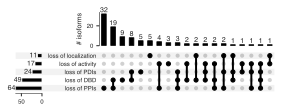

In [38]:
ppis = list(set(list(pairs[pairs["dn_ppi"] == True]["clone_acc_alt"])))
pdis = list(set(list(pairs[pairs["dn_pdi"] == True]["clone_acc_alt"])))
activ = list(set(list(pairs[pairs["dn_activ"] == True]["clone_acc_alt"])))
dbd = list(set(list(pairs[pairs["dn_dbd"] == True]["clone_acc_alt"])))
loc = list(set(list(pairs[pairs["dn_loc"] == True]["clone_acc_alt"])))

contents = {"loss of PPIs": ppis, "loss of PDIs": pdis, "loss of activity": activ, "loss of DBD": dbd,
            "loss of localization": loc}
contents = upsetplot.from_contents(contents)

all_dn = set(ppis).union(set(pdis)).union(set(activ)).union(set(dbd))
print(len(all_dn))

fig = plt.figure(figsize=(3, 2))
d = plot(contents, fig=fig, sort_by="cardinality", show_counts=True, element_size=12, 
     intersection_plot_elements=4, totals_plot_elements=3)
d["intersections"].set_ylabel("# isoforms")
d["intersections"].grid(False)
d["totals"].grid(False)

fig.savefig("../../figures/fig7/DN_negreg_upset.pdf", dpi="figure", bbox_inches="tight")

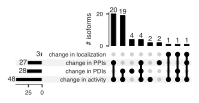

In [39]:
rw = pairs[pairs["dn_cat"] == "rewire"]
ppis = list(set(list(rw[rw["y2h_cat"] == "PPI rewire"]["clone_acc_alt"])))
pdis = list(set(list(rw[rw["y1h_cat"].str.contains("PDI")]["clone_acc_alt"])))
activ = list(set(list(rw[rw["m1h_cat"] != "NA"]["clone_acc_alt"])))
loc = list(set(list(rw[rw["loc_cat"] == "localization change"]["clone_acc_alt"])))

contents = {"change in PPIs": ppis, "change in PDIs": pdis, "change in activity": activ, 
            "change in localization": loc}
contents = upsetplot.from_contents(contents)

fig = plt.figure(figsize=(3, 2))
d = plot(contents, fig=fig, sort_by="cardinality", show_counts=True, element_size=12, 
         intersection_plot_elements=4, totals_plot_elements=3)
d["intersections"].set_ylabel("# isoforms")
d["intersections"].grid(False)
d["totals"].grid(False)

fig.savefig("../../figures/fig7/DN_rewire_upset.pdf", dpi="figure", bbox_inches="tight")

364


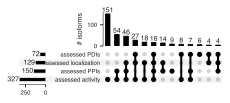

In [40]:
ppis = list(set(list(pairs[pairs["y2h_cat"] != "NA"]["clone_acc_alt"])))
pdis = list(set(list(pairs[pairs["y1h_cat"] != "NA"]["clone_acc_alt"])))
activ = list(set(list(pairs[pairs["m1h_cat"] != "NA"]["clone_acc_alt"])))
loc = list(set(list(pairs[pairs["loc_cat"] != "NA"]["clone_acc_alt"])))

contents = {"assessed PPIs": ppis, "assessed PDIs": pdis, "assessed activity": activ, "assessed localization": loc}
contents = upsetplot.from_contents(contents)

all_as = set(ppis).union(set(pdis)).union(set(activ))
print(len(all_as))

fig = plt.figure(figsize=(3, 2))
d = plot(contents, fig=fig, sort_by="cardinality", show_counts=True, element_size=12, 
         intersection_plot_elements=4, totals_plot_elements=3)
d["intersections"].set_ylabel("# isoforms")
d["intersections"].grid(False)
d["totals"].grid(False)

fig.savefig("../../figures/fig7/DN_pairs_assessed_upset.pdf", dpi="figure", bbox_inches="tight")

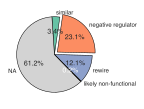

In [41]:
y = np.array([len(pairs[pairs["dn_short"] == "rewire"]), 
              len(pairs[pairs["dn_short"] == "DN"]),
              len(pairs[pairs["dn_short"] == "similar"]),
              len(pairs[pairs["dn_short"] == "NA"]), 
              len(pairs[pairs["dn_short"] == "likely"])])
labels = ["rewire", "negative regulator", "similar", "NA", "likely non-functional"]
colors = [sns.color_palette("Set2")[2], sns.color_palette("Set2")[1], sns.color_palette("Set2")[0],
          "lightgray", "darkgray"]

fig = plt.figure(figsize=(1.75, 1.75))
ws, ls, ns = plt.pie(y, labels=labels, colors=colors, autopct='%1.1f%%', startangle=-45, explode=(0, 0.1, 0, 0, 0))
for w in ws:
    w.set_linewidth(0.5)
    w.set_edgecolor("black")
ns[4].set_color("white")

fig.savefig("../../figures/fig7/dn_pie.incl_NA.pdf", dpi="figure", bbox_inches="tight")

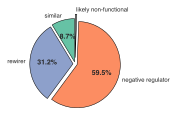

In [42]:
ys = np.array([len(pairs[pairs["dn_short"] == "similar"]),
               len(pairs[pairs["dn_short"] == "rewire"]), 
               len(pairs[pairs["dn_short"] == "DN"]),
               len(pairs[pairs["dn_short"] == "likely"])])
labels = ["similar", "rewirer", "negative regulator", "likely non-functional"]
colors = [sns.color_palette("Set2")[0], sns.color_palette("Set2")[2], sns.color_palette("Set2")[1], "darkgray"]

fig, ax = plt.subplots(figsize=(2.0, 2.0), subplot_kw=dict(aspect="equal"))
ws, ls, ns = ax.pie(ys, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90, 
                    explode=(0.05, 0.05, 0.05, 0.15))

for n, w in zip(ns, ws):
    w.set_linewidth(0.5)
    w.set_edgecolor("black")
    n.set_fontweight("bold")
ns[3].set_text("")

fig.savefig("../../figures/fig7/dn_pie.no_NA.pdf", dpi="figure", bbox_inches="tight")

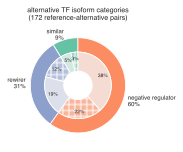

In [43]:
outer_ys = np.array([len(pairs[(pairs["dn_short"] == "similar")]),
                     len(pairs[(pairs["dn_short"] == "rewire")]), 
                     len(pairs[(pairs["dn_short"] == "DN")])])
outer_labels = ["similar\n%0.0f%%" % round((outer_ys[0]/np.sum(outer_ys)*100)),
                "rewirer\n%0.0f%%" % round((outer_ys[1]/np.sum(outer_ys)*100)), 
                "negative regulator\n%0.0f%%" % round((outer_ys[2]/np.sum(outer_ys)*100))]
outer_colors = [sns.color_palette("Set2")[0], sns.color_palette("Set2")[2], sns.color_palette("Set2")[1]]

inner_ys = np.array([len(pairs[(pairs["dn_short"] == "similar") & (pairs["is_alt_novel_isoform"])]), 
                     len(pairs[(pairs["dn_short"] == "similar") & (~pairs["is_alt_novel_isoform"])]),
                     len(pairs[(pairs["dn_short"] == "rewire") & (pairs["is_alt_novel_isoform"])]), 
                     len(pairs[(pairs["dn_short"] == "rewire") & (~pairs["is_alt_novel_isoform"])]), 
                     len(pairs[(pairs["dn_short"] == "DN") & (pairs["is_alt_novel_isoform"])]),
                     len(pairs[(pairs["dn_short"] == "DN") & (~pairs["is_alt_novel_isoform"])])])
inner_colors = [sns.light_palette(sns.color_palette("Set2")[0])[3], 
                sns.light_palette(sns.color_palette("Set2")[0])[1], 
                sns.light_palette(sns.color_palette("Set2")[2])[3], 
                sns.light_palette(sns.color_palette("Set2")[2])[1], 
                sns.light_palette(sns.color_palette("Set2")[1])[3], 
                sns.light_palette(sns.color_palette("Set2")[1])[1]]
hatches = ['++', '', '++', '', '++', '']


fig, ax = plt.subplots(figsize=(2.2, 2.2), subplot_kw=dict(aspect="equal"))

o_ws, o_ls = ax.pie(outer_ys, colors=outer_colors, labels=outer_labels,
                    startangle=90, radius=1, wedgeprops=dict(width=0.3, edgecolor='w'))
i_ws, i_ls, i_ns = ax.pie(inner_ys, colors=inner_colors, autopct='%0.0f%%', 
                          startangle=90, radius=0.7, 
                          wedgeprops=dict(width=0.4, edgecolor='w'),
                          textprops={'fontsize': 5}, pctdistance=0.8)

for i, w in enumerate(i_ws):
    w.set(hatch=hatches[i])
    
ax.set_title("alternative TF isoform categories\n(%s reference-alternative pairs)" % (np.sum(outer_ys)))

fig.savefig("../../figures/fig7/dn_pie.novel_nested.pdf", dpi="figure", bbox_inches="tight")

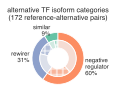

In [44]:
outer_ys = np.array([len(pairs[(pairs["dn_short"] == "similar")]),
                     len(pairs[(pairs["dn_short"] == "rewire")]), 
                     len(pairs[(pairs["dn_short"] == "DN")])])
outer_labels = ["similar\n%0.0f%%" % round((outer_ys[0]/np.sum(outer_ys)*100)),
                "rewirer\n%0.0f%%" % round((outer_ys[1]/np.sum(outer_ys)*100)), 
                "negative\nregulator\n%0.0f%%" % round((outer_ys[2]/np.sum(outer_ys)*100))]
outer_colors = [sns.color_palette("Set2")[0], sns.color_palette("Set2")[2], sns.color_palette("Set2")[1]]

inner_ys = np.array([len(pairs[(pairs["dn_short"] == "similar") & (pairs["is_alt_novel_isoform"])]), 
                     len(pairs[(pairs["dn_short"] == "similar") & (~pairs["is_alt_novel_isoform"])]),
                     len(pairs[(pairs["dn_short"] == "rewire") & (pairs["is_alt_novel_isoform"])]), 
                     len(pairs[(pairs["dn_short"] == "rewire") & (~pairs["is_alt_novel_isoform"])]), 
                     len(pairs[(pairs["dn_short"] == "DN") & (pairs["is_alt_novel_isoform"])]),
                     len(pairs[(pairs["dn_short"] == "DN") & (~pairs["is_alt_novel_isoform"])])])
inner_colors = [sns.light_palette(sns.color_palette("Set2")[0])[3], 
                sns.light_palette(sns.color_palette("Set2")[0])[1], 
                sns.light_palette(sns.color_palette("Set2")[2])[3], 
                sns.light_palette(sns.color_palette("Set2")[2])[1], 
                sns.light_palette(sns.color_palette("Set2")[1])[3], 
                sns.light_palette(sns.color_palette("Set2")[1])[1]]
hatches = ['++', '', '++', '', '++', '']


fig, ax = plt.subplots(figsize=(1.2, 1.2), subplot_kw=dict(aspect="equal"))

o_ws, o_ls = ax.pie(outer_ys, colors=outer_colors, labels=outer_labels,
                    startangle=90, radius=1, wedgeprops=dict(width=0.3, edgecolor='w'))
i_ws, i_ns = ax.pie(inner_ys, colors=inner_colors, 
                          startangle=90, radius=0.7, 
                          wedgeprops=dict(width=0.3, edgecolor='w'))

for i, w in enumerate(i_ws):
    w.set(hatch=hatches[i])
    
ax.set_title("alternative TF isoform categories\n(%s reference-alternative pairs)" % (np.sum(outer_ys)))

fig.savefig("../../figures/fig7/dn_pie.novel_nested.no_labels.pdf", dpi="figure", bbox_inches="tight")

In [45]:
# create df for stacked bar chart
delta_pdis = pairs[~pairs["y1h_cat"].isin(["NA", "no PDI change"])]
pdis_vc = pd.DataFrame(delta_pdis.dn_short.value_counts()).reset_index()

delta_ppis = pairs[~pairs["y2h_cat"].isin(["NA", "no PPI change (important PPIs)", "no PPI change (all PPIs)"])]
ppis_vc = pd.DataFrame(delta_ppis.dn_short.value_counts()).reset_index()

delta_activ = pairs[~pairs["m1h_cat"].isin(["NA", "similar"])]
activ_vc = pd.DataFrame(delta_activ.dn_short.value_counts()).reset_index()

delta_loc = pairs[~pairs["loc_cat"].isin(["NA", "no localization change"])]
loc_vc = pd.DataFrame(delta_loc.dn_short.value_counts()).reset_index()

mrg = pdis_vc.merge(ppis_vc, on="index", how="outer").merge(activ_vc, on="index", how="outer").merge(loc_vc, on="index", how="outer")
mrg.fillna(0, inplace=True)
mrg.columns = ["index", "PDIs", "PPIs", "activity", "localization"]

to_plot = pd.melt(mrg, id_vars="index")
to_plot.sample(5)

,index,variable,value
9,rewire,activity,16
11,likely,activity,1
6,NA,PPIs,12
14,NA,localization,6
5,rewire,PPIs,27


In [46]:
# make stacked barchart situation
tmp = pairs[pairs["dn_short"] == "DN"]
dn_pdi_change = len(tmp[tmp["dn_pdi"] == True])
dn_ppi_change = len(tmp[tmp["dn_ppi"] == True])
dn_activ_change = len(tmp[tmp["dn_activ"] == True])
dn_dbd_change = len(tmp[tmp["dn_dbd"] == True])
dn_loc_change = len(tmp[tmp["dn_loc"] == True])
tot_dn = dn_pdi_change + dn_ppi_change + dn_activ_change + dn_dbd_change + dn_loc_change

tmp = pairs[pairs["dn_short"] == "rewire"]
rw_pdi_change = len(tmp[~tmp["y1h_cat"].isin(["NA", "no PDI change"])])
rw_ppi_change = len(tmp[~tmp["y2h_cat"].isin(["NA", "no PPI change (important PPIs)"])])
rw_activ_change = len(tmp[tmp["m1h_cat"] != "NA"])
rw_dbd_change = len(tmp[tmp["dbd_pct_lost"] > 0])
rw_loc_change = len(tmp[tmp["loc_cat"] == "localization change"])
tot_rw = rw_pdi_change + rw_ppi_change + rw_activ_change + rw_dbd_change + rw_loc_change

df = pd.DataFrame.from_dict({"DN": {"pdi_change": dn_pdi_change/tot_dn*100, 
                                    "ppi_change": dn_ppi_change/tot_dn*100,
                                    "activ_change": dn_activ_change/tot_dn*100, 
                                    "dbd_change": dn_dbd_change/tot_dn*100,
                                    "loc_change": dn_loc_change/tot_dn*100},
                             "rewire": {"pdi_change": rw_pdi_change/tot_rw*100,
                                        "ppi_change": rw_ppi_change/tot_rw*100,
                                        "activ_change": rw_activ_change/tot_rw*100,
                                        "dbd_change": rw_dbd_change/tot_rw*100,
                                        "loc_change": rw_loc_change/tot_rw*100}})
df["DN_cumsum"] = np.cumsum(df["DN"])
df["rw_cumsum"] = np.cumsum(df["rewire"])
df

,DN,rewire,DN_cumsum,rw_cumsum
pdi_change,14.545455,22.123894,14.545455,22.123894
ppi_change,38.787879,30.088496,53.333333,52.212389
activ_change,10.303030,42.477876,63.636364,94.690265
dbd_change,29.696970,2.654867,93.333333,97.345133
loc_change,6.666667,2.654867,100.000000,100.000000


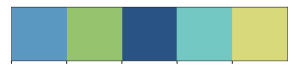

In [47]:
colors = met_brewer.met_brew(name="Hokusai3", n=5, brew_type="discrete")
sns.palplot(colors)

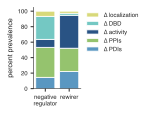

In [48]:
fig, ax = plt.subplots(figsize=(0.85, 1.5))

xs = ["negative regulator", "rewirer"]
y1 = list(df[["DN", "rewire"]].loc["pdi_change"])
y2 = list(df[["DN", "rewire"]].loc["ppi_change"])
b2 = np.add(y1, y2)
y3 = list(df[["DN", "rewire"]].loc["activ_change"])
b3 = np.add(b2, y3)
y4 = list(df[["DN", "rewire"]].loc["dbd_change"])
b4 = np.add(b3, y4)
y5 = list(df[["DN", "rewire"]].loc["loc_change"])

ax.bar(xs, y1, color=colors[0], label="∆ PDIs")
ax.bar(xs, y2, bottom=y1, color=colors[1], label="∆ PPIs")
ax.bar(xs, y3, bottom=b2, color=colors[2], label="∆ activity")
ax.bar(xs, y4, bottom=b3, color=colors[3], label="∆ DBD")
ax.bar(xs, y5, bottom=b4, color=colors[4], label="∆ localization")

# add legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1.01, 1), frameon=False)

ax.set_ylabel("percent prevalence")
ax.set_xticklabels(["negative\nregulator", "rewirer"])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig("../../figures/fig7/dn_stacked_bar.pdf", dpi="figure", bbox_inches="tight")

In [49]:
# make stacked barchart situation of all assays (to compare)
tmp = pairs[pairs["dn_short"] != "NA"]
pdi_assessed = len(tmp[tmp["y1h_cat"] != "NA"])
ppi_assessed = len(tmp[tmp["y2h_cat"] != "NA"])
activ_assessed = len(tmp[tmp["m1h_cat"] != "NA"])
loc_assessed = len(tmp[tmp["loc_cat"] != "NA"])

tot_assessed = pdi_assessed + ppi_assessed + activ_assessed + loc_assessed

nc = pd.DataFrame.from_dict({"assessed": {"pdi": pdi_assessed/tot_assessed*100, 
                                    "ppi": ppi_assessed/tot_assessed*100,
                                    "activ": activ_assessed/tot_assessed*100,
                                          "loc": loc_assessed/tot_assessed*100}})
nc["assessed_cumsum"] = np.cumsum(nc["assessed"])
nc

,assessed,assessed_cumsum
activ,34.573304,34.573304
loc,21.663020,56.236324
pdi,14.660832,70.897155
ppi,29.102845,100.000000


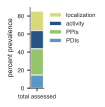

In [50]:
fig, ax = plt.subplots(figsize=(0.25, 1.5))

xs = ["assessed"]
y1 = list(nc[["assessed"]].loc["pdi"])
y2 = list(nc[["assessed"]].loc["ppi"])
b2 = np.add(y1, y2)
y3 = list(nc[["assessed"]].loc["activ"])
b3 = np.add(y2, y3)
y4 = list(nc[["assessed"]].loc["loc"])

ax.bar(xs, y1, color=colors[0], label="PDIs")
ax.bar(xs, y2, bottom=y1, color=colors[1], label="PPIs")
ax.bar(xs, y3, bottom=b2, color=colors[2], label="activity")
ax.bar(xs, y4, bottom=b3, color=colors[4], label="localization")

# add legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1.01, 1), frameon=False)

ax.set_ylabel("percent prevalence")
ax.set_xticklabels(["total assessed"])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig("../../figures/fig7/dn_stacked_bar.nc.pdf", dpi="figure", bbox_inches="tight")

In [51]:
genes_w_dn = pairs[pairs["dn_short"] == "DN"][["gene_symbol", "family"]].drop_duplicates()
genes_w_rw = pairs[pairs["dn_short"] == "rewire"][["gene_symbol", "family"]].drop_duplicates()
genes_w_sim = pairs[pairs["dn_short"] == "similar"][["gene_symbol", "family"]].drop_duplicates()
tot_genes = pairs[["gene_symbol", "family"]].drop_duplicates()

tot_genes_per_f = tot_genes.groupby("family")["gene_symbol"].agg("count").reset_index()
dn_genes_per_f = genes_w_dn.groupby("family")["gene_symbol"].agg("count").reset_index()
rw_genes_per_f = genes_w_rw.groupby("family")["gene_symbol"].agg("count").reset_index()
sim_genes_per_f = genes_w_sim.groupby("family")["gene_symbol"].agg("count").reset_index()

family_cats = tot_genes_per_f.merge(dn_genes_per_f, 
                                    on="family", how="left").merge(rw_genes_per_f, 
                                                                   on="family", how="left").merge(sim_genes_per_f,
                                                                                                  on="family",
                                                                                                  how="left")
family_cats.fillna(0, inplace=True)
family_cats.columns = ["family", "tot", "dn", "rw", "sim"]

family_cats["tot_p"] = family_cats["tot"]/family_cats["tot"].sum(axis=0)*100
family_cats["dn_p"] = family_cats["dn"]/family_cats["dn"].sum(axis=0)*100
family_cats["rw_p"] = family_cats["rw"]/family_cats["rw"].sum(axis=0)*100
family_cats["sim_p"] = family_cats["sim"]/family_cats["sim"].sum(axis=0)*100
family_cats.sort_values(by="tot", ascending=False).head(11)

,family,tot,dn,rw,sim,tot_p,dn_p,rw_p,sim_p
2,C2H2 ZF,101,16.0,8.0,3.0,41.056911,22.222222,19.047619,25.000000
17,Homeodomain,23,11.0,7.0,1.0,9.349593,15.277778,16.666667,8.333333
23,Nuclear receptor,19,8.0,8.0,2.0,7.723577,11.111111,19.047619,16.666667
34,bHLH,16,6.0,4.0,1.0,6.504065,8.333333,9.523810,8.333333
11,Ets,11,1.0,1.0,0.0,4.471545,1.388889,2.380952,0.000000
35,bZIP,10,6.0,2.0,1.0,4.065041,8.333333,4.761905,8.333333
15,HMG/Sox,6,1.0,1.0,0.0,2.439024,1.388889,2.380952,0.000000
28,SMAD,6,3.0,1.0,1.0,2.439024,4.166667,2.380952,8.333333
9,E2F,4,2.0,0.0,0.0,1.626016,2.777778,0.000000,0.000000
30,T-box,4,1.0,1.0,0.0,1.626016,1.388889,2.380952,0.000000


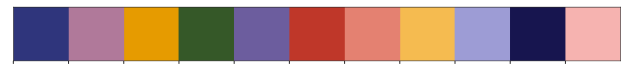

In [52]:
colors = met_brewer.met_brew(name="Renoir", n=11, brew_type="discrete")
sns.palplot(colors)

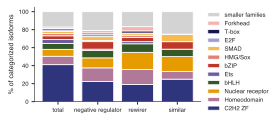

In [53]:
fig, ax = plt.subplots(figsize=(3, 1.75))

xs = ["total", "negative regulator", "rewirer", "similar"]

b = np.zeros(4)
c = 0
for i, row in family_cats.sort_values(by="tot", ascending=False).head(11).iterrows():
    y = list(row[["tot_p", "dn_p", "rw_p", "sim_p"]])
    ax.bar(xs, y, bottom=b, label=row.family, color=colors[c])
    b = np.add(b, y)
    c += 1

ax.bar(xs, np.subtract([100, 100, 100, 100], b), bottom=b, label="smaller families", color="lightgray")
ax.set_ylabel("% of categorized isoforms")

# add legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1.01, 1), frameon=False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig("../../figures/fig7/dn_families_stacked_bar.pdf", dpi="figure", bbox_inches="tight")

## 5. are there differences in condensate formation between categories?

In [54]:
def condensate_cat_either(row):
    if row.condensate_cat_only_HEK == "Difference" or row.condensate_cat_only_U2OS == "Difference":
        return "Difference"
    elif row.condensate_cat_only_HEK == "No difference" and row.condensate_cat_only_U2OS == "No difference":
        return "No difference"
    elif row.condensate_cat_only_HEK == "No difference" or row.condensate_cat_only_U2OS == "No difference":
        return "No difference"
    else:
        return np.nan
    
pairs["condensate_cat_either"] = pairs.apply(condensate_cat_either, axis=1)
pairs.condensate_cat_either.value_counts()

No difference    88
Difference       41
Name: condensate_cat_either, dtype: int64

In [55]:
def condensate_cat_both(row):
    if row.condensate_cat_only_HEK == "Difference" and row.condensate_cat_only_U2OS == "Difference":
        return "Difference"
    elif row.condensate_cat_only_HEK == "No difference" and row.condensate_cat_only_U2OS == "No difference":
        return "No difference"
    else:
        return np.nan
    
pairs["condensate_cat_both"] = pairs.apply(condensate_cat_both, axis=1)
pairs.condensate_cat_both.value_counts()

No difference    88
Difference       21
Name: condensate_cat_both, dtype: int64

In [56]:
from scipy.stats import fisher_exact

In [57]:
fe = np.zeros((2, 2))

tmp_nonan = pairs[~pd.isnull(pairs["condensate_cat_either"])]

fe[0, 0] = len(tmp_nonan[(tmp_nonan["dn_short"] == "DN") & 
                    (tmp_nonan["condensate_cat_either"] == "Difference")].clone_acc_alt.unique())
fe[1, 0] = len(tmp_nonan[(tmp_nonan["dn_short"] != "DN") & 
                    (tmp_nonan["condensate_cat_either"] == "Difference")].clone_acc_alt.unique())
fe[0, 1] = len(tmp_nonan[(tmp_nonan["dn_short"] == "DN") &
                    (tmp_nonan["condensate_cat_either"] == "No difference")].clone_acc_alt.unique())
fe[1, 1] = len(tmp_nonan[(tmp_nonan["dn_short"] != "DN") & 
                    (tmp_nonan["condensate_cat_either"] == "No difference")].clone_acc_alt.unique())
fe

array([[20., 37.],
       [21., 51.]])

In [58]:
p = fisher_exact(fe)[1]
print(p)

0.5684691626007984


In [59]:
tots = pd.DataFrame(tmp_nonan.dn_short.value_counts())
sig = pd.DataFrame(tmp_nonan[tmp_nonan["condensate_cat_either"] == "Difference"].dn_short.value_counts())
con_st = tots.join(sig, lsuffix="_tot", rsuffix="_diff")
con_st = con_st.loc[["DN", "rewire", "similar", "NA"]]
con_st = con_st/con_st.sum(axis=0)
con_st.fillna(0, inplace=True)
con_st

,dn_short_tot,dn_short_diff
DN,0.445312,0.487805
rewire,0.304688,0.317073
similar,0.015625,0.000000
NA,0.234375,0.195122


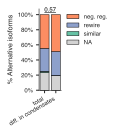

In [60]:
fig, ax = plt.subplots(figsize=(0.4, 1.5))

xs = ["total", "diff. in condensates"]
y1 = list(con_st[["dn_short_tot", "dn_short_diff"]].loc["NA"])
y2 = list(con_st[["dn_short_tot", "dn_short_diff"]].loc["similar"])
b2 = np.add(y1, y2)
y3 = list(con_st[["dn_short_tot", "dn_short_diff"]].loc["rewire"])
b3 = np.add(b2, y3)
y4 = list(con_st[["dn_short_tot", "dn_short_diff"]].loc["DN"])

ax.bar(xs, y1, color=dn_pal["NA"], label="NA", edgecolor="black", linewidth=0.5)
ax.bar(xs, y2, bottom=y1, color=dn_pal["similar"], label="similar", edgecolor="black", linewidth=0.5)
ax.bar(xs, y3, bottom=b2, color=dn_pal["rewire"], label="rewire", edgecolor="black", linewidth=0.5)
ax.bar(xs, y4, bottom=b3, color=dn_pal["DN"], label="neg. reg.", edgecolor="black", linewidth=0.5)

# annotate pval
annotate_pval(ax, 0, 1, 1.025, 0, 1.025, p, fontsize-1)

# add legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1.01, 1), frameon=False)

ax.set_ylabel("% Alternative isoforms")
ax.set_xticklabels(xs, rotation=30, ha="right", va="top")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(["%s%%" % x for x in [0, 20, 40, 60, 80, 100]])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig("../../figures/fig7/dn_stacked_bar_condensates.either.pdf", dpi="figure", bbox_inches="tight")

In [61]:
fe = np.zeros((2, 2))

tmp_nonan = pairs[~pd.isnull(pairs["condensate_cat_both"])]

fe[0, 0] = len(tmp_nonan[(tmp_nonan["dn_short"] == "DN") & 
                    (tmp_nonan["condensate_cat_both"] == "Difference")].clone_acc_alt.unique())
fe[1, 0] = len(tmp_nonan[(tmp_nonan["dn_short"] != "DN") & 
                    (tmp_nonan["condensate_cat_both"] == "Difference")].clone_acc_alt.unique())
fe[0, 1] = len(tmp_nonan[(tmp_nonan["dn_short"] == "DN") &
                    (tmp_nonan["condensate_cat_both"] == "No difference")].clone_acc_alt.unique())
fe[1, 1] = len(tmp_nonan[(tmp_nonan["dn_short"] != "DN") & 
                    (tmp_nonan["condensate_cat_both"] == "No difference")].clone_acc_alt.unique())
fe

array([[11., 37.],
       [10., 51.]])

In [62]:
p = fisher_exact(fe)[1]
print(p)

0.46614048580588063


In [63]:
tots = pd.DataFrame(tmp_nonan.dn_short.value_counts())
sig = pd.DataFrame(tmp_nonan[tmp_nonan["condensate_cat_both"] == "Difference"].dn_short.value_counts())
con_st = tots.join(sig, lsuffix="_tot", rsuffix="_diff")
con_st = con_st.loc[["DN", "rewire", "similar", "NA"]]
con_st = con_st/con_st.sum(axis=0)
con_st.fillna(0, inplace=True)
con_st

,dn_short_tot,dn_short_diff
DN,0.444444,0.523810
rewire,0.287037,0.238095
similar,0.018519,0.000000
NA,0.250000,0.238095


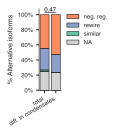

In [64]:
fig, ax = plt.subplots(figsize=(0.4, 1.5))

xs = ["total", "diff. in condensates"]
y1 = list(con_st[["dn_short_tot", "dn_short_diff"]].loc["NA"])
y2 = list(con_st[["dn_short_tot", "dn_short_diff"]].loc["similar"])
b2 = np.add(y1, y2)
y3 = list(con_st[["dn_short_tot", "dn_short_diff"]].loc["rewire"])
b3 = np.add(b2, y3)
y4 = list(con_st[["dn_short_tot", "dn_short_diff"]].loc["DN"])

ax.bar(xs, y1, color=dn_pal["NA"], label="NA", edgecolor="black", linewidth=0.5)
ax.bar(xs, y2, bottom=y1, color=dn_pal["similar"], label="similar", edgecolor="black", linewidth=0.5)
ax.bar(xs, y3, bottom=b2, color=dn_pal["rewire"], label="rewire", edgecolor="black", linewidth=0.5)
ax.bar(xs, y4, bottom=b3, color=dn_pal["DN"], label="neg. reg.", edgecolor="black", linewidth=0.5)

# annotate pval
annotate_pval(ax, 0, 1, 1.025, 0, 1.025, p, fontsize-1)

# add legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1.01, 1), frameon=False)

ax.set_ylabel("% Alternative isoforms")
ax.set_xticklabels(xs, rotation=30, ha="right", va="top")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(["%s%%" % x for x in [0, 20, 40, 60, 80, 100]])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig("../../figures/fig7/dn_stacked_bar_condensates.both.pdf", dpi="figure", bbox_inches="tight")

## 6. join data with Joung et al. o/ex

In [65]:
tfs = load_annotated_TFiso1_collection()

reading from cache


In [66]:
def pd_translate(row):
    s = Seq(row["ORF sequence"])
    aa = s.translate()
    return str(aa)

joung_orf["seq_aa"] = joung_orf.apply(pd_translate, axis=1)

In [67]:
tf_id_map = {}
for tf in tfs:
    isos = tfs[tf]
    for i, iso in enumerate(isos.isoforms):
        sub_dict = {}
        try: 
            iso_clone_acc = iso.clone_acc
        except AttributeError:
            continue

        try:
            iso_seq_aa = iso.aa_seq_GENCODE
        except AttributeError:
            iso_seq_aa = iso.aa_seq
        iso_ensts = iso.ensembl_transcript_ids

        
        # first try to match based on aa seq
        joung_sub = joung_orf[joung_orf["seq_aa"] == iso_seq_aa]
        
        if len(joung_sub) > 0:
            sub_dict["match_type"] = "seq_aa"
            sub_dict["joung_id"] = joung_sub["Name"].iloc[0]
        
        # if not found, then try ensts
        if len(joung_sub) == 0:
            if iso_ensts is None:
                continue
            
            for iso_enst in iso_ensts:
                joung_sub = joung_orf[joung_orf["RefSeq and Gencode ID"].str.contains(iso_enst)]
                if len(joung_sub) > 0:
                    continue
            
            if len(joung_sub) > 0:
                sub_dict["match_type"] = "enst"
                sub_dict["joung_id"] = joung_sub["Name"].iloc[0]
            else:
                continue
        
        sub_dict["enst"] = iso_ensts
        sub_dict["seq_aa"] = iso_seq_aa
        tf_id_map[iso_clone_acc] = sub_dict

In [68]:
tf_id_map_df = pd.DataFrame.from_dict(tf_id_map, orient="index").reset_index()
print(len(tf_id_map_df))
tf_id_map_df.sample(5)

403


,index,match_type,joung_id,enst,seq_aa
341,ZNF544|1/7|10A12,seq_aa,TFORF3176,"[ENST00000269829, ENST00000596652]",MEARSMLVPPQASVCFEDVAMAFTQEEWEQLDLAQRTLYREVTLET...
13,ZNF691|2/2|05G02,seq_aa,TFORF1724,"[ENST00000372504, ENST00000630961]",MAQISSGGGGQSRCLLFALGSEMGSEKEQSPEPHLPEEGEGGKPWR...
321,ZNF397|2/5|11C06,seq_aa,TFORF3407,[ENST00000261333],MAVESGVISTLIPQDPPEQELILVKVEDNFSWDEKFKQNGSTQSCQ...
359,ZNF419|2/4|02F10,seq_aa,TFORF2177,[ENST00000442920],MAAAALRDPAQGYVTFEDVAVYFSQEEWRLLDDAQRLLYRNVMLEN...
4,POU2F1|2/2|04D01,seq_aa,TFORF3019,[ENST00000541643],MNNPSETSKPSMESGDGNTGTQTNGLDFQKQPVPVGGAISTAQAQA...


In [69]:
joung_orf = joung_orf.merge(tf_id_map_df, left_on="Name", right_on="joung_id", how="left", suffixes=("_joung",
                                                                                                     "_tf1p0"))
joung_orf.sample(5)

,Source,Name,RefSeq Gene Name,RefSeq and Gencode ID,Isoform ID,Insert,ORF sequence,Barcode Sequence,Epitope Tag,Unsorted M1,...,Sorted M4,Sorted M5,Sorted M6,Sorted M7,seq_aa_joung,index,match_type,joung_id,enst,seq_aa_tf1p0
3405,Broad GPP,TFORF3405,KCNIP4,NM_025221.5,KCNIP4-5,ATCGATTGATCAACAAGTTTGTACAAAAAAGTTGGCATGAATGTGC...,ATGAATGTGCGGAGGGTGGAAAGCATTTCGGCTCAGCTGGAGGAGG...,GATGACTATTTTGACTTTCTTTCT,V5,1.636358,...,0.768759,0.762186,0.761199,0.903249,MNVRRVESISAQLEEASSTGGFLYAQNSTKRSIKERLMKLLPCSAA...,NaN,NaN,NaN,NaN,NaN
2803,Genewiz,TFORF2803,ETV2,"XM_011526624,NM_001300974,ENST00000479824",ETV2-3,ACCGCCACCATGGCGTGCACAGCCTGGGACTCTTGGAGCGGCGCCT...,ATGGCGTGCACAGCCTGGGACTCTTGGAGCGGCGCCTCGCAGACCC...,AGCCTCAAGCCATTCGGTTAGCTC,None,1.683787,...,0.695187,0.789433,0.566128,0.691163,MACTAWDSWSGASQTLGPAPLGPGPIPAAGSEGAAGQNCVPVAGEA...,ETV2|3/4|12H10,seq_aa,TFORF2803,[ENST00000479824],MACTAWDSWSGASQTLGPAPLGPGPIPAAGSEGAAGQNCVPVAGEA...
1641,Genewiz,TFORF1642,ZNF426,"NM_001300883,XM_017027293,ENST00000593003",ZNF426-1,ACCGCCACCATGGATTCAGTGACCTTTGACGATGTGGCTGTGGACT...,ATGGATTCAGTGACCTTTGACGATGTGGCTGTGGACTTCACCCAGG...,CTAGTGCACTCATCCGTATGATGC,None,0.126719,...,0.560174,1.550232,0.496438,0.805095,MDSVTFDDVAVDFTQEEWTLLDSTQRSLYSDVMLENYKNLATVGGQ...,NaN,NaN,NaN,NaN,NaN
2518,Genewiz,TFORF2519,ZFP37,"NM_001282518,ENST00000555206",ZFP37-2,ACCGCCACCATGTCGGTCTCCAGCGGCGTCCAGATTCTGACAAAGC...,ATGTCGGTCTCCAGCGGCGTCCAGATTCTGACAAAGCCAGAGACCG...,CCACCACCCGGTACTCCAAGATAT,None,0.085302,...,6.376806,0.188267,2.224447,1.103412,MSVSSGVQILTKPETVDRRRSAETTKEAGRPLEMAVSEPEASAAKE...,NaN,NaN,NaN,NaN,NaN
1460,Genewiz,TFORF1461,LMX1B,"NM_001174146,ENST00000355497",LMX1B-2,ACCGCCACCATGGATATAGCAACAGGTCCCGAGTCGCTGGAGAGGT...,ATGGATATAGCAACAGGTCCCGAGTCGCTGGAGAGGTGCTTCCCTC...,CACTCGTGAGGAGCCTAAGGATTC,None,0.662658,...,1.217147,0.730746,1.002198,2.376063,MDIATGPESLERCFPRGQTDCAKMLDGIKMEEHALRPGPATLGVLL...,NaN,NaN,NaN,NaN,NaN


In [70]:
joung_data = joung_orf.merge(joung_data, on="Name", how="left")

In [71]:
dn_ref = pairs[["gene_symbol", "family", "clone_acc_ref", "is_ref_novel_isoform", "is_MANE_select_isoform_cloned",
             "dn_short"]].drop_duplicates()
dn_ref.columns = ["gene_name", "family", "tf1p0_id", "is_novel", "is_MANE_select", "dn_cat"]
dn_ref["dn_cat"] = "ref"
dn_ref["iso_status"] = "ref"

In [72]:
dn_alt = pairs[["gene_symbol", "family", "clone_acc_alt", "is_alt_novel_isoform", "is_MANE_select_isoform_cloned",
             "dn_short"]].drop_duplicates()
dn_alt.columns = ["gene_name", "family", "tf1p0_id", "is_novel", "is_MANE_select", "dn_cat"]
dn_alt["is_MANE_select"] = False # assuming none of the alts are the MANE select
dn_alt["iso_status"] = "alt"

In [73]:
dn_cats = dn_ref.append(dn_alt).drop_duplicates()

In [74]:
dn_cats = dn_cats.merge(joung_data, left_on="tf1p0_id", right_on="index", how="left")

In [75]:
dn_cats.iso_status.value_counts()

alt    446
ref    246
Name: iso_status, dtype: int64

In [76]:
dn_cats[~pd.isnull(dn_cats["Name"])].iso_status.value_counts()

ref    220
alt    183
Name: iso_status, dtype: int64

In [77]:
refs_inc = len(dn_cats[(~pd.isnull(dn_cats["Name"])) & (dn_cats["iso_status"] == "ref")])
refs_tf1p0 = len(dn_cats[dn_cats["iso_status"] == "ref"])
print("%% of our ref seqs included in joung: %s" % (refs_inc/refs_tf1p0*100))

% of our ref seqs included in joung: 89.43089430894308


In [78]:
alts_inc = len(dn_cats[(~pd.isnull(dn_cats["Name"])) & (dn_cats["iso_status"] == "alt")])
alts_tf1p0 = len(dn_cats[dn_cats["iso_status"] == "alt"])
print("%% of our alt seqs included in joung: %s" % (alts_inc/alts_tf1p0*100))

% of our alt seqs included in joung: 41.03139013452915


In [79]:
dn_cats["orf_len"] = dn_cats["seq_aa_joung"].str.len()

In [80]:
joung_down_tf1p0_map = joung_down_map.merge(dn_cats[["TF ORF", "tf1p0_id", "iso_status", "dn_cat", "orf_len"]],
                                           left_on="TF", right_on="TF ORF")
print(len(joung_down_tf1p0_map))
print(len(joung_down_tf1p0_map["TF ORF"].unique()))

76546
400


In [81]:
joung_down_tf1p0_map.fillna("NA", inplace=True)

In [82]:
joung_tf1p0_cnts = joung_down_tf1p0_map.groupby(["TF", "tf1p0_id", "iso_status", 
                                                 "dn_cat", "orf_len"])["TF ORF"].agg("count").reset_index()
joung_tf1p0_cnts.columns = ["TF", "tf1p0_id", "iso_status", "dn_cat", "orf_len", "tot_cell_cnt"]

In [83]:
dn_cats_nonan = dn_cats[~pd.isnull(dn_cats["Diffusion P-value"])]
len(dn_cats_nonan)

401

In [84]:
dn_cats_nonan["neglog_diff_pval"] = -np.log10(dn_cats_nonan["Diffusion P-value"])
dn_cats_nonan.fillna("NA", inplace=True)

In [85]:
dn_cats_nonan_ref = dn_cats_nonan[dn_cats_nonan["iso_status"] == "ref"]
dn_cats_nonan_alt = dn_cats_nonan[dn_cats_nonan["iso_status"] == "alt"]
dn_cats_nonan_diff = dn_cats_nonan_ref.merge(dn_cats_nonan_alt, on=["gene_name", "family", "RefSeq Gene Name"],
                                             how="left", suffixes=("_ref", "_alt"))
dn_cats_nonan_diff["diff_pval_diff"] = dn_cats_nonan_diff["Diffusion P-value_ref"] - dn_cats_nonan_diff["Diffusion P-value_alt"]
dn_cats_nonan_diff["diff_diff_diff"] = dn_cats_nonan_diff["Diffusion difference_ref"] - dn_cats_nonan_diff["Diffusion difference_alt"]

dn_cats_nonan_diff["abs_ddd"] = np.abs(dn_cats_nonan_diff["diff_diff_diff"])

In [86]:
dn_cats_nonan[dn_cats_nonan["gene_name"] == "CREB1"]

,gene_name,family,tf1p0_id,is_novel,is_MANE_select,dn_cat,iso_status,Source,Name,RefSeq Gene Name,...,joung_id,enst,seq_aa_tf1p0,TF ORF,Diffusion P-value,Diffusion difference,RNA Velocity P-value,RNA Velocity difference,orf_len,neglog_diff_pval
23,CREB1,bZIP,CREB1|2/2|01F12,False,True,ref,ref,Genewiz,TFORF2364,CREB1,...,TFORF2364,"[ENST00000353267, ENST00000430624]",MTMESGAENQQSGDAAVTEAENQQMTVQAQPQIATLAQVSMPAAHA...,TFORF2364-CREB1,0.351410,-0.004511,0.085578,-0.018990,327.0,0.454186
284,CREB1,bZIP,CREB1|1/2|02E01,False,False,DN,alt,Broad GPP,TFORF3026,CREB1,...,TFORF3026,[ENST00000432329],MTMESGAENQQSGDAAVTEAENQQMTVQAQPQIATLAQVSMPAAHA...,TFORF3026-CREB1,0.035065,0.005142,0.389913,0.005432,341.0,1.455122


In [87]:
dn_cats_nonan[dn_cats_nonan["dn_cat"] != "NA"].sort_values(by="neglog_diff_pval", ascending=False).head(10)

,gene_name,family,tf1p0_id,is_novel,is_MANE_select,dn_cat,iso_status,Source,Name,RefSeq Gene Name,...,joung_id,enst,seq_aa_tf1p0,TF ORF,Diffusion P-value,Diffusion difference,RNA Velocity P-value,RNA Velocity difference,orf_len,neglog_diff_pval
4,GRHL3,Grainyhead,GRHL3|3/7|08G09,False,True,ref,ref,Genewiz,TFORF2165,GRHL3,...,TFORF2165,[ENST00000361548],MSNELDFRSVRLLKNDPVNLQKFSYTSEDEAWKTYLENPLTAATKA...,TFORF2165-GRHL3,2.270000e-07,-0.030514,0.000001,-0.039517,602.0,6.643974
416,HMBOX1,Homeodomain,HMBOX1|3/5|03E06,False,False,rewire,alt,Genewiz,TFORF1140,HMBOX1,...,TFORF1140,[ENST00000558662],MLSSFPVVLLETMSHYTDEPRFTIEQIDLLQRLRRTGMTKHEILHA...,TFORF1140-HMBOX1,1.350000e-05,0.003310,0.086120,0.000862,405.0,4.869666
306,KLF7,C2H2 ZF,KLF7|3/8|10B10,False,False,rewire,alt,Genewiz,TFORF0978,KLF7,...,TFORF0978,[ENST00000412414],MFPSWPTCLELERYLQTEPRRISETFGEDLDCFLHASPPPCIEESF...,TFORF0978-KLF7,2.400000e-05,0.003548,0.091175,0.001495,274.0,4.619789
253,GRHL3,Grainyhead,GRHL3|4/7|08F09,False,False,rewire,alt,Genewiz,TFORF2168,GRHL3,...,TFORF2168,[ENST00000356046],MMRVNGDDDSVAALSFLYDYYMGPKEKRILSSSTGGRNDQGKRYYH...,TFORF2168-GRHL3,3.710000e-05,-0.010852,0.013126,-0.012732,556.0,4.430626
45,RBPJ,CSL,RBPJ|2/4|07B11,False,True,ref,ref,Genewiz,TFORF0610,RBPJ,...,TFORF0610,"[ENST00000342320, ENST00000355476]",MAWIKRKFGERPPPKRLTREAMRNYLKERGDQTVLILHAKVAQKSY...,TFORF0610-RBPJ,3.830000e-05,0.005815,0.018722,0.008279,486.0,4.416801
266,PBX1,Homeodomain,PBX1|2/2|02C05,False,False,DN,alt,Genewiz,TFORF0429,PBX1,...,TFORF0429,[ENST00000367897],MDEQPRLMHSHAGVGMAGHPGLSQHLQDGAGGTEGEGGRKQDIGDI...,TFORF0429-PBX1,4.790000e-05,0.002412,0.000239,-0.002553,347.0,4.319664
285,DLX1,Homeodomain,DLX1|2/2|07E09,False,False,DN,alt,Genewiz,TFORF1452,DLX1,...,TFORF1452,[ENST00000341900],MTMTTMPESLNSPVSGKAVFMEFGPPNQQMSPSPMSHGHYSMHCLH...,TFORF1452-DLX1,5.180000e-05,0.001693,0.000548,-0.004723,129.0,4.285670
8,LHX8,Homeodomain,LHX8|2/2|09C01,False,True,ref,ref,Genewiz,TFORF0824,LHX8,...,TFORF0824,[ENST00000356261],MSEECGRTTALAAGRTRKGAGEEGLVSPEGAGDEDSCSSSAPLSPS...,TFORF0824-LHX8,6.230000e-05,0.004710,0.137505,0.002104,346.0,4.205512
223,MEIS3,Homeodomain,MEIS3|4/5|07H10,False,True,ref,ref,Genewiz,TFORF2581,MEIS3,...,TFORF2581,[ENST00000558555],MARRYDELPHYPGIVDGPAALASFPETVPAVPGPYGPHRPPQPLPP...,TFORF2581-MEIS3,9.420000e-05,0.002445,0.176984,-0.000935,375.0,4.025949
100,ZNF483,C2H2 ZF,ZNF483|1/3|06B02,False,False,ref,ref,Genewiz,TFORF1222,ZNF483,...,TFORF1222,[ENST00000358151],MQAVVPLNKMTAISPEPQTLASTEQNEVPRVVTSGEQEAILRGNAA...,TFORF1222-ZNF483,1.007220e-04,0.003061,0.001842,-0.002282,256.0,3.996876


annot clone: GRHL3|3/7|08G09 | ha: center | va: top
annot clone: HMBOX1|3/5|03E06 | ha: right | va: bottom
annot clone: KLF7|3/8|10B10 | ha: right | va: top
annot clone: GRHL3|4/7|08F09 | ha: right | va: center
annot clone: PBX1|2/2|02C05 | ha: right | va: bottom
annot clone: DLX1|2/2|07E09 | ha: right | va: bottom


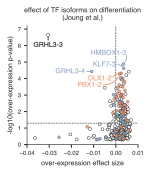

In [88]:
fig = plt.figure(figsize=(2, 2.2))

ax = sns.scatterplot(data=dn_cats_nonan[dn_cats_nonan["dn_cat"].isin(["ref"])], 
                x="Diffusion difference", y="neglog_diff_pval", 
                color="white", linewidth=0.5, edgecolor="black", alpha=0.8, zorder=10,
                **{"s": 9})

sns.scatterplot(data=dn_cats_nonan[dn_cats_nonan["dn_cat"].isin(["similar", "rewire", "DN"])], 
                x="Diffusion difference", y="neglog_diff_pval", 
                hue="dn_cat", palette=dn_pal, linewidth=0.25, edgecolor="black", alpha=0.8, zorder=10,
                **{"s": 9}, ax=ax)

for annot_clone, ha, va, offset, relpos, cs in zip(["GRHL3|3/7|08G09", "HMBOX1|3/5|03E06", 
                                                    "KLF7|3/8|10B10", "GRHL3|4/7|08F09", "PBX1|2/2|02C05",
                                                    "DLX1|2/2|07E09"],
                                                    ["center", "right", "right", "right", "right", "right"],
                                                    ["top", "bottom", "top", "center", "bottom", "bottom"],
                                                    [(0, -7), (3, 8), (-8, 7), (-7, 0), (-20, -15), (-8, -8)],
                                                    [(0.5, 1), (1, 0.5), (1, 0.5), (1, 0.5), (1, 0.5), (1, 0.5)],
                                                    ["arc3,rad=0", "arc3,rad=-0.3", "arc3,rad=-0.3", "arc3,rad=0",
                                                     "arc3,rad=0.3", "arc3,rad=-0.3"]):
    row = dn_cats_nonan[dn_cats_nonan["tf1p0_id"] == annot_clone].iloc[0]
    if row["dn_cat"] == "ref":
        color = "black"
    else:
        color = dn_pal[row["dn_cat"]]
    print("annot clone: %s | ha: %s | va: %s" % (annot_clone, ha, va))
    
    shorter_id = annot_clone.split("|")[0] + "-" + annot_clone.split("|")[1].split("/")[0]
    ax.annotate(shorter_id, xy=(row["Diffusion difference"], row["neglog_diff_pval"]), xytext=offset,
                color=color, ha=ha, va=va,
                textcoords='offset points', bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'),
                arrowprops=dict(arrowstyle="-", color=color, relpos=relpos, connectionstyle=cs))

ax.set_xlabel("over-expression effect size")
ax.set_ylabel("-log10(over-expression p-value)")
ax.set_title("effect of TF isoforms on differentiation\n(Joung et al.)")

ax.set_xlim((-0.04, 0.01))
ax.set_ylim((-0.01, 7.2))
ax.axhline(y=-np.log10(0.05), linestyle="dashed", color="black", linewidth=0.5)
ax.axvline(x=0, linestyle="dashed", color="black", linewidth=0.5)

ax.get_legend().remove()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig("../../figures/fig7/Joung_Volcano.pdf", dpi="figure", bbox_inches="tight")

In [89]:
joung_cells["Name"] = joung_cells["TF"].str.strip().str.split("-", expand=True)[0]
print(len(joung_cells))

# # filter out anything with score < 0.2
joung_cells = joung_cells[joung_cells["prediction.score.max"] > 0.2]
print(len(joung_cells))

28825
23604


In [90]:
joung_cells_grp = joung_cells.groupby(["Name", "TF", "predicted.id"])["batch"].agg("count").reset_index()

In [91]:
joung_tf1p0_cnts["cell_cnt_qcut"] = pd.qcut(joung_tf1p0_cnts["tot_cell_cnt"], q=4, labels=[1, 2, 3, 4])
dn_cats_nonan = dn_cats_nonan.merge(joung_tf1p0_cnts[["TF", "tot_cell_cnt", "cell_cnt_qcut"]], 
                                    left_on="TF ORF", right_on="TF")

In [92]:
tot_cell_cnt = dn_cats_nonan[["Name", "TF", "tot_cell_cnt"]].drop_duplicates()
diff_cell_cnt = joung_cells.groupby(["Name", "TF"])["batch"].agg("count").reset_index()
cell_cnt = tot_cell_cnt.merge(diff_cell_cnt, on=["Name", "TF"], how="left")
cell_cnt.fillna(0, inplace=True)
cell_cnt.columns = ["Name", "TF", "tot_cell_cnt", "diff_cell_cnt"]

orf_enr = cell_cnt.merge(joung_cells_grp, on=["Name", "TF"], how="left")
orf_enr["batch"].fillna(0, inplace=True)

orf_enr.columns = ["Name", "TF", "tot_cell_cnt", "diff_cell_cnt", "predicted.id", "id_cell_cnt"]
orf_enr["perc_cells_of_diff_tf"] = orf_enr["id_cell_cnt"]/orf_enr["diff_cell_cnt"]
orf_enr["perc_cells_of_tot_tf"] = orf_enr["id_cell_cnt"]/orf_enr["tot_cell_cnt"]

In [93]:
orf_enr_dn = orf_enr.merge(dn_cats_nonan[["gene_name", "Name", "tf1p0_id",
                                          "dn_cat"]], on="Name").drop_duplicates(subset=["tf1p0_id",
                                                                                         "predicted.id",
                                                                                         "dn_cat"])

In [94]:
has_alt = list(orf_enr_dn[orf_enr_dn["dn_cat"] != "ref"]["gene_name"].unique())
orf_enr_dn_filt = orf_enr_dn[orf_enr_dn["gene_name"].isin(has_alt)]

has_ref = list(orf_enr_dn_filt[orf_enr_dn_filt["dn_cat"] == "ref"]["gene_name"].unique())
orf_enr_dn_filt = orf_enr_dn_filt[orf_enr_dn_filt["gene_name"].isin(has_ref)]
len(orf_enr_dn_filt)

1052

In [95]:
orf_enr_dn_filt["dn_cat_s"] = pd.Categorical(orf_enr_dn_filt["dn_cat"], ["ref", "similar", "rewire", 
                                                                         "DN", "NA", "likely"])
orf_enr_dn_filt = orf_enr_dn_filt.sort_values(by=["gene_name", "dn_cat_s"])

In [96]:
cell_cnt["undiff_cell_cnt"] = cell_cnt["tot_cell_cnt"] - cell_cnt["diff_cell_cnt"]
len(cell_cnt)

400

In [97]:
cell_cnt["diff_cell_perc"] = (cell_cnt["diff_cell_cnt"]/cell_cnt["tot_cell_cnt"])*100
cell_cnt["undiff_cell_perc"] = (cell_cnt["undiff_cell_cnt"]/cell_cnt["tot_cell_cnt"])*100
cell_cnt[cell_cnt["TF"].str.contains("GRHL3")]

,Name,TF,tot_cell_cnt,diff_cell_cnt,undiff_cell_cnt,diff_cell_perc,undiff_cell_perc
4,TFORF2165,TFORF2165-GRHL3,111,36.0,75.0,32.432432,67.567568
222,TFORF2166,TFORF2166-GRHL3,47,0.0,47.0,0.000000,100.000000
223,TFORF2167,TFORF2167-GRHL3,500,12.0,488.0,2.400000,97.600000
224,TFORF2168,TFORF2168-GRHL3,152,40.0,112.0,26.315789,73.684211


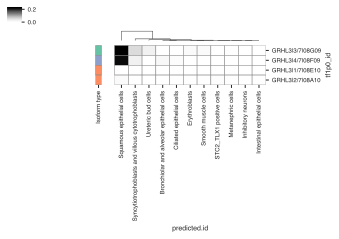

In [98]:
tmp = orf_enr_dn_filt[orf_enr_dn_filt["tf1p0_id"].str.contains("GRHL3")].pivot(index="tf1p0_id", 
                                                                               columns="predicted.id", 
                                                                               values="perc_cells_of_tot_tf")
tmp.drop(np.nan, axis=1, inplace=True)
tmp = tmp.loc[["GRHL3|3/7|08G09", "GRHL3|4/7|08F09", "GRHL3|1/7|08E10", "GRHL3|2/7|08A10"]]
tmp.fillna(0, inplace=True)

idx = pd.DataFrame(tmp.index)
idx = idx.merge(orf_enr_dn_filt[["tf1p0_id", "dn_cat"]], on="tf1p0_id").drop_duplicates().set_index("tf1p0_id")
idx["Isoform type"] = idx.dn_cat.map(dn_pal)

g = sns.clustermap(tmp, cmap="Greys", row_cluster=False, row_colors=idx["Isoform type"],
                   figsize=(4, 1), yticklabels=True, cbar_pos=(0, 1, 0.05, 0.2), linewidth=0.5, linecolor="grey")

g.savefig("../../figures/fig7/Joung_GRHL3_hm.pdf", bbox_inches="tight", dpi="figure")

## 8. plot expression profiles of isoform categories

In [99]:
# use same downsample as prev figs
means_gtex_downsample = df_gtex.groupby(df_gtex.columns.map(metadata_gtex_dummy['body_site']), axis=1).mean()

In [100]:
# calculate expression ratios - dev
per_gene_dev = ((2 ** df_dev - 1)
                .groupby(genes_dev)
                .transform('sum'))
f_dev = (((2 ** df_dev - 1) / per_gene_dev)
        .groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']),
         axis=1)
        .mean())
f_dev = f_dev * ((per_gene_dev.groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']),
                                             axis=1)
                                             .mean() >= 1)
                                         .applymap(lambda x: {False: np.nan, True: 1}[x]))  # only count fractions if gene TPM is >= 1

f_dev = f_dev * 100

In [101]:
# calculate expression ratios - gtex
per_gene_gtex = ((2 ** df_gtex - 1)
                .groupby(genes_gtex)
                .transform('sum'))
f_gtex = (((2 ** df_gtex - 1) / per_gene_gtex)
        .groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1)
        .mean())
f_gtex = f_gtex * (per_gene_gtex.groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1).mean() >= 1).applymap(lambda x: {False: np.nan, True: 1}[x])  # only count fractions if gene TPM is >= 1

f_gtex = f_gtex * 100

In [102]:
# calculate expression ratios -gtex downsampled
per_gene_gtex_ds = ((2 ** df_gtex.loc[:,metadata_gtex_dummy.index] - 1)
                   .groupby(genes_gtex)
                   .transform('sum'))

f_gtex_downsample = (((2 ** df_gtex - 1) / per_gene_gtex)
        .groupby(df_gtex.columns.map(metadata_gtex_dummy['body_site']), axis=1)
        .mean())
f_gtex_downsample = f_gtex_downsample * (per_gene_gtex.groupby(df_gtex.columns.map(metadata_gtex_dummy['body_site']), axis=1).mean() >= 1).applymap(lambda x: {False: np.nan, True: 1}[x])  # only count fractions if gene TPM is >= 1

f_gtex_downsample = f_gtex_downsample * 100

In [103]:
# calculate gene-level tissue specificities
gene_dev_nonan_taus, gene_dev_nan_taus, gene_dev_array_max = calculate_tau(per_gene_dev.drop_duplicates())
gene_gtex_nonan_taus, gene_gtex_nan_taus, gene_gtex_array_max = calculate_tau(per_gene_gtex.drop_duplicates())
gene_gtex_ds_nonan_taus, gene_gtex_ds_nan_taus, gene_gtex_ds_array_max = calculate_tau(per_gene_gtex_ds.drop_duplicates())

In [104]:
gene_taus = pd.DataFrame()
gene_taus["UID"] = per_gene_dev.drop_duplicates().index
gene_taus["dev_tau"] = gene_dev_nan_taus
gene_taus["gtex_tau"] = gene_gtex_nan_taus
gene_taus["gtex_ds_tau"] = gene_gtex_ds_nan_taus
gene_taus["gene_name"] = gene_taus["UID"].str.split("|", expand=True)[0]
gene_taus.sample(5)

,UID,dev_tau,gtex_tau,gtex_ds_tau,gene_name
177,ZNF131|1/5|02B05 ZNF131-201_ZNF131-206_ZNF131-214,0.898462,0.970354,0.962528,ZNF131
147,TEAD2|1/2|12B02 TEAD2-201,0.876391,0.960270,0.901339,TEAD2
187,ZNF207|1/4|01E12 ZNF207-203,0.557196,0.678015,0.568800,ZNF207
180,ZNF169|3/5|07D12 ZNF169-204,0.690485,0.755678,0.709720,ZNF169
241,ZSCAN21|1/3|10H09 ZSCAN21-201,0.497534,0.723863,0.724407,ZSCAN21


In [105]:
# join w pairs table
dev_ratios = f_dev.reset_index()
dev_ratios["clone_acc"] = dev_ratios["UID"].str.split(" ", expand=True)[0].astype(str)
dev_ratios = dev_ratios[dev_ratios["clone_acc"] != "noclone"]
len(dev_ratios)

693

In [106]:
gtex_ratios = f_gtex.reset_index()
gtex_ratios["clone_acc"] = gtex_ratios["UID"].str.split(" ", expand=True)[0].astype(str)
gtex_ratios = gtex_ratios[gtex_ratios["clone_acc"] != "noclone"]
len(gtex_ratios)

693

In [107]:
gtex_ds_ratios = f_gtex_downsample.reset_index()
gtex_ds_ratios["clone_acc"] = gtex_ds_ratios["UID"].str.split(" ", expand=True)[0].astype(str)
gtex_ds_ratios = gtex_ds_ratios[gtex_ds_ratios["clone_acc"] != "noclone"]
len(gtex_ds_ratios)

693

In [108]:
dev_ratios = dev_ratios.merge(dn_cats, left_on="clone_acc", right_on="tf1p0_id")
gtex_ratios = gtex_ratios.merge(dn_cats, left_on="clone_acc", right_on="tf1p0_id")
gtex_ds_ratios = gtex_ds_ratios.merge(dn_cats, left_on="clone_acc", right_on="tf1p0_id")
print(len(dev_ratios))
print(len(gtex_ratios))
print(len(gtex_ds_ratios))

692
692
692


In [109]:
dn_cats = dn_cats.merge(gene_taus, on="gene_name")
print(len(dn_cats))
dn_cats.head()

692


,gene_name,family,tf1p0_id,is_novel,is_MANE_select,dn_cat,iso_status,Source,Name,RefSeq Gene Name,...,TF ORF,Diffusion P-value,Diffusion difference,RNA Velocity P-value,RNA Velocity difference,orf_len,UID,dev_tau,gtex_tau,gtex_ds_tau
0,ZBTB18,C2H2 ZF,ZBTB18|1/2|04E08,False,True,ref,ref,Genewiz,TFORF2495,ZBTB18,...,TFORF2495-ZBTB18,0.172521,0.002115,0.168074,-0.004946,531.0,ZBTB18|1/2|04E08 ZBTB18-201,0.913550,0.969912,0.958172
1,ZBTB18,C2H2 ZF,ZBTB18|2/2|12E05,False,False,rewire,alt,Genewiz,TFORF2494,ZBTB18,...,TFORF2494-ZBTB18,0.006114,0.003615,0.244046,-0.003313,522.0,ZBTB18|1/2|04E08 ZBTB18-201,0.913550,0.969912,0.958172
2,PRRX1,Homeodomain,PRRX1|2/3|09F06,False,True,ref,ref,Genewiz,TFORF1217,PRRX1,...,TFORF1217-PRRX1,0.365286,0.000400,0.000021,-0.009730,245.0,PRRX1|1/3|09C07 PRRX1-202,0.882687,0.907518,0.848223
3,PRRX1,Homeodomain,PRRX1|1/3|09C07,False,False,NA,alt,Genewiz,TFORF1218,PRRX1,...,TFORF1218-PRRX1,0.006905,0.002594,0.000440,-0.001672,217.0,PRRX1|1/3|09C07 PRRX1-202,0.882687,0.907518,0.848223
4,PRRX1,Homeodomain,PRRX1|3/3|09H08,False,False,rewire,alt,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,PRRX1|1/3|09C07 PRRX1-202,0.882687,0.907518,0.848223


In [110]:
ref_expr = dn_cats.groupby(["gene_name", "family", "dn_cat", "dev_tau",
                            "gtex_tau", "gtex_ds_tau"])["tf1p0_id"].agg("count").reset_index()
ref_expr = ref_expr.pivot(index="gene_name",
                          columns="dn_cat", values="tf1p0_id")
ref_expr.fillna(0, inplace=True)

In [111]:
def categorize_gene(row):
    if row.DN > 0 and row.rewire == 0 and row.similar == 0:
        return "DN"
    elif row.rewire > 0 and row.DN == 0 and row.similar == 0:
        return "rewire"
    elif row.similar > 0 and row.DN == 0 and row.rewire == 0:
        return "similar"
    elif row.NA > 0:
        return "NA"
    else:
        return "combination"
    
ref_expr["gene_cat"] = ref_expr.apply(categorize_gene, axis=1)
ref_expr.reset_index(inplace=True)
ref_expr = ref_expr.merge(dn_cats[["gene_name", "family", "dev_tau", "gtex_tau", "gtex_ds_tau"]],
                          on="gene_name").drop_duplicates()
print(len(ref_expr))
ref_expr.sample(5)

246


,gene_name,DN,NA,likely,ref,rewire,similar,gene_cat,family,dev_tau,gtex_tau,gtex_ds_tau
57,EBF2,0.0,1.0,0.0,1.0,0.0,0.0,NA,EBF1,0.951577,0.957773,0.928485
619,ZNF473,0.0,1.0,0.0,1.0,0.0,0.0,NA,C2H2 ZF,0.975493,0.981905,0.964522
299,PBX1,1.0,0.0,0.0,1.0,0.0,0.0,DN,Homeodomain,0.781706,0.909373,0.894019
54,EBF1,2.0,0.0,0.0,1.0,0.0,0.0,DN,EBF1,0.943090,0.877520,0.831534
575,ZNF341,0.0,1.0,0.0,1.0,0.0,0.0,NA,C2H2 ZF,0.748095,0.726947,0.736202


0.01512182005591258
0.07214993911531936
0.8392322130718609
0.9697827848906592


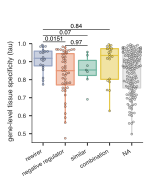

In [112]:
fig, ax = nice_boxplot(ref_expr, "dev_tau", "gene_cat", dn_pal, ["rewire", "DN", "similar", "combination", "NA"], 
            [1.01, 1.045, 1.08, 0.99], 0.35, "", ["rewirer", "negative regulator", "similar", "combination", "NA"], 
            "gene-level tissue specificity (tau)", False, (0.3, 1.23), 
            "developmental gene expression\nclassified TF genes")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticklabels(["rewirer", "negative regulator", "similar", "combination", "NA"], rotation=30, 
                   ha="right", va="top")
ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax.set_xlabel("")
ax.set_ylabel("gene-level tissue specificity (tau)", position=(0, 0.38))

# manually set left axis so it stops at 1.0
ax.set_ylim((0.45, 1.2))
ax.spines['left'].set_visible(False)
ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
axes_to_data = ax.transAxes + ax.transData.inverted()
left_spine_in_data_coords = axes_to_data.transform((0, 0))
ax.plot([left_spine_in_data_coords[0], left_spine_in_data_coords[0]], [0.45, 1],
         color=ax.spines['bottom'].get_edgecolor(), linewidth=ax.spines['bottom'].get_linewidth())


fig.savefig("../../figures/fig7/DN_DevTau_Gene_Boxplot.pdf", dpi="figure", bbox_inches="tight")

0.03180937982488903
0.17524424540000594
0.6359445511344555
0.7714958195988528


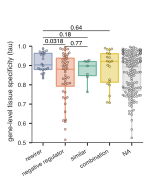

In [113]:
fig, ax = nice_boxplot(ref_expr, "gtex_ds_tau", "gene_cat", dn_pal, ["rewire", "DN", "similar", "combination", "NA"], 
            [1.01, 1.045, 1.08, 0.999], 0.35, "", ["rewirer", "negative regulator", "similar", "combination", "NA"], 
            "gene-level tissue specificity (tau)", False, (0.3, 1.23), 
            "developmental gene expression\nclassified TF genes")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticklabels(["rewirer", "negative regulator", "similar", "combination", "NA"], rotation=30, 
                   ha="right", va="top")
ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax.set_xlabel("")
ax.set_ylabel("gene-level tissue specificity (tau)", position=(0, 0.38))

# manually set left axis so it stops at 1.0
ax.set_ylim((0.5, 1.2))
ax.spines['left'].set_visible(False)
ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
axes_to_data = ax.transAxes + ax.transData.inverted()
left_spine_in_data_coords = axes_to_data.transform((0, 0))
ax.plot([left_spine_in_data_coords[0], left_spine_in_data_coords[0]], [0.5, 1],
         color=ax.spines['bottom'].get_edgecolor(), linewidth=ax.spines['bottom'].get_linewidth())

fig.savefig("../../figures/fig7/DN_GTExDsTau_Gene_Boxplot.pdf", dpi="figure", bbox_inches="tight")

## 9. load BRCA data

In [114]:
brca_cnts_f = "../../data/processed/Nathans_analysis/Breast_cancer/isoCounts.BreastCancer.txt"
brca_tx_f = "../../data/processed/Nathans_analysis/Breast_cancer/transcript.BreastCancer.txt"
pam50_f = "../../data/processed/Nathans_analysis/Breast_cancer/groups.PAM50.txt"
bulk_f = "../../data/processed/Nathans_analysis/Breast_cancer/groups.BreastCancer_ratios.txt"

In [115]:
skiprows=list(range(96320, 96387))+list(range(99680,99687))
brca = pd.read_table(brca_tx_f, sep="\t", skiprows=skiprows)
brca.shape

(99774, 1223)

In [116]:
pam50_samps = pd.read_table(pam50_f, header=None)
pam50_samps.columns = ["file", "samp_type_id", "samp_type"]
pam50_samps["tcga_id"] = pam50_samps["file"].str.split(".", expand=True)[0]
pam50_samps.samp_type.value_counts()

Luminal A        232
Luminal B        125
controls         119
Basal-like       101
HER2-enriched     58
Normal-like        8
Name: samp_type, dtype: int64

In [117]:
bulk_samps = pd.read_table(bulk_f, header=None)
bulk_samps.columns = ["file", "samp_type_id", "samp_type"]
bulk_samps["tcga_id"] = bulk_samps["file"].str.split(".", expand=True)[0]
bulk_samps.samp_type.value_counts()

BC          1104
controls     119
Name: samp_type, dtype: int64

In [118]:
# map brca sample types
brca_samps = list(bulk_samps[bulk_samps["samp_type"] != "controls"]["tcga_id"])
print("# breast cancer samples: %s" % len(brca_samps))


# same ctrls in both
ctrl_samps = list(pam50_samps[pam50_samps["samp_type"] == "controls"]["tcga_id"])
print("# control samples: %s" % len(ctrl_samps))

luma_samps = list(pam50_samps[pam50_samps["samp_type"] == "Luminal A"]["tcga_id"])
print("# Luminal A samples: %s" % len(luma_samps))

lumb_samps = list(pam50_samps[pam50_samps["samp_type"] == "Luminal B"]["tcga_id"])
print("# Luminal B samples: %s" % len(lumb_samps))

tn_samps = list(pam50_samps[pam50_samps["samp_type"] == "Basal-like"]["tcga_id"])
print("# Basal-like samples: %s" % len(tn_samps))

her2_samps = list(pam50_samps[pam50_samps["samp_type"] == "HER2-enriched"]["tcga_id"])
print("# HER2-enriched samples: %s" % len(her2_samps))

norm_samps = list(pam50_samps[pam50_samps["samp_type"] == "Normal-like"]["tcga_id"])
print("# Normal-like samples: %s" % len(norm_samps))

# breast cancer samples: 1104
# control samples: 119
# Luminal A samples: 232
# Luminal B samples: 125
# Basal-like samples: 101
# HER2-enriched samples: 58
# Normal-like samples: 8


In [119]:
# one brca samp is weirdly missing, remove
brca_samps = [x for x in brca_samps if x in brca.columns]
len(brca_samps)

1103

In [120]:
## patient is the 3rd value in the barcode
## source: https://docs.gdc.cancer.gov/Encyclopedia/pages/TCGA_Barcode/
bulk_samps["patient_id"] = bulk_samps["tcga_id"].str.split("-", expand=True)[2]
pam50_samps["patient_id"] = pam50_samps["tcga_id"].str.split("-", expand=True)[2]

In [121]:
tcga_samps = bulk_samps.merge(pam50_samps, on=["tcga_id", "patient_id"], how="outer",
                              suffixes=("_brca", "_pam50"))
print(len(tcga_samps))

1223


In [122]:
tcga_ctrls = tcga_samps[(tcga_samps["samp_type_brca"] == "controls") | (tcga_samps["samp_type_pam50"] == "controls")]
len(tcga_ctrls)

119

In [123]:
tcga_tumors = tcga_samps[(tcga_samps["samp_type_brca"] != "controls") | (tcga_samps["samp_type_pam50"] != "controls")]
len(tcga_tumors)

1104

In [124]:
tcga_paired = tcga_ctrls.merge(tcga_tumors, on=["patient_id"], suffixes=("_ctrl", "_tumor"))
print(len(tcga_paired))

123


In [125]:
# qc on the paired samples to make sure nothing is mis-categorized
tcga_paired["ctrl_samp_id"] = tcga_paired["tcga_id_ctrl"].str[13:15].astype(int)
tcga_paired["tumor_samp_id"] = tcga_paired["tcga_id_tumor"].str[13:15].astype(int)

In [126]:
# ctrls should all be between 10-19
# tumors should all be between 01-09
def flag_samp(row, samp_type):
    if samp_type == "tumor":
        if row.tumor_samp_id >= 10:
            return True
        else:
            return False
    else:
        if row.ctrl_samp_id <= 9:
            return True
        elif row.ctrl_samp_id >= 19:
            return True
        else:
            return False
        
tcga_paired["ctrl_flag"] = tcga_paired.apply(flag_samp, samp_type="ctrl", axis=1)
tcga_paired["tumor_flag"] = tcga_paired.apply(flag_samp, samp_type="tumor", axis=1)

tcga_paired.ctrl_flag.value_counts()

False    117
True       6
Name: ctrl_flag, dtype: int64

In [127]:
tcga_paired[tcga_paired["ctrl_flag"]]

,file_brca_ctrl,samp_type_id_brca_ctrl,samp_type_brca_ctrl,tcga_id_ctrl,patient_id,file_pam50_ctrl,samp_type_id_pam50_ctrl,samp_type_pam50_ctrl,file_brca_tumor,samp_type_id_brca_tumor,samp_type_brca_tumor,tcga_id_tumor,file_pam50_tumor,samp_type_id_pam50_tumor,samp_type_pam50_tumor,ctrl_samp_id,tumor_samp_id,ctrl_flag,tumor_flag
32,TCGA-E2-A15K-06A-11R-A12P-07.qsort.read1,2,controls,TCGA-E2-A15K-06A-11R-A12P-07,A15K,TCGA-E2-A15K-06A-11R-A12P-07.qsort.read1,6.0,controls,TCGA-E2-A15K-01A-11R-A12P-07.qsort.read1,1,BC,TCGA-E2-A15K-01A-11R-A12P-07,TCGA-E2-A15K-01A-11R-A12P-07.qsort.read1,4.0,Luminal B,6,1,True,False
45,TCGA-E2-A15E-06A-11R-A12D-07.qsort.read1,2,controls,TCGA-E2-A15E-06A-11R-A12D-07,A15E,TCGA-E2-A15E-06A-11R-A12D-07.qsort.read1,6.0,controls,TCGA-E2-A15E-01A-11R-A12D-07.qsort.read1,1,BC,TCGA-E2-A15E-01A-11R-A12D-07,TCGA-E2-A15E-01A-11R-A12D-07.qsort.read1,3.0,Luminal A,6,1,True,False
60,TCGA-E2-A15A-06A-11R-A12D-07.qsort.read1,2,controls,TCGA-E2-A15A-06A-11R-A12D-07,A15A,TCGA-E2-A15A-06A-11R-A12D-07.qsort.read1,6.0,controls,TCGA-E2-A15A-01A-11R-A12D-07.qsort.read1,1,BC,TCGA-E2-A15A-01A-11R-A12D-07,TCGA-E2-A15A-01A-11R-A12D-07.qsort.read1,4.0,Luminal B,6,1,True,False
87,TCGA-BH-A18V-06A-11R-A213-07.qsort.read1,2,controls,TCGA-BH-A18V-06A-11R-A213-07,A18V,TCGA-BH-A18V-06A-11R-A213-07.qsort.read1,6.0,controls,TCGA-BH-A18V-01A-11R-A12D-07.qsort.read1,1,BC,TCGA-BH-A18V-01A-11R-A12D-07,TCGA-BH-A18V-01A-11R-A12D-07.qsort.read1,1.0,Basal-like,6,1,True,False
93,TCGA-BH-A1FE-06A-11R-A213-07.qsort.read1,2,controls,TCGA-BH-A1FE-06A-11R-A213-07,A1FE,TCGA-BH-A1FE-06A-11R-A213-07.qsort.read1,6.0,controls,TCGA-BH-A1FE-01A-11R-A13Q-07.qsort.read1,1,BC,TCGA-BH-A1FE-01A-11R-A13Q-07,NaN,NaN,NaN,6,1,True,False
112,TCGA-AC-A6IX-06A-11R-A32P-07.qsort.read1,2,controls,TCGA-AC-A6IX-06A-11R-A32P-07,A6IX,TCGA-AC-A6IX-06A-11R-A32P-07.qsort.read1,6.0,controls,TCGA-AC-A6IX-01A-12R-A32P-07.qsort.read1,1,BC,TCGA-AC-A6IX-01A-12R-A32P-07,NaN,NaN,NaN,6,1,True,False


In [128]:
# looks like these 6 samples are marked as "controls" in Nathan's file but correspond to metastases
# according to https://gdc.cancer.gov/resources-tcga-users/tcga-code-tables/sample-type-codes 
# sample type 06 = Metastastic
# filter these out
tcga_paired = tcga_paired[~tcga_paired["ctrl_flag"]]

In [129]:
tcga_paired.tumor_flag.value_counts()

False    117
Name: tumor_flag, dtype: int64

In [130]:
# all looks good on tumor end

In [131]:
# are there any dupes?
print(len(tcga_paired.tcga_id_ctrl.unique()))
print(len(tcga_paired.tcga_id_tumor.unique()))

112
117


In [132]:
# it looks like a few control samples are repeated
tmp = tcga_paired.groupby("tcga_id_ctrl")["file_brca_ctrl"].agg("count").reset_index()
tmp[tmp["file_brca_ctrl"] > 1]

,tcga_id_ctrl,file_brca_ctrl
3,TCGA-A7-A0DB-11A-33R-A089-07,3
4,TCGA-A7-A0DC-11A-41R-A089-07,2
5,TCGA-A7-A13E-11A-61R-A12P-07,3


In [133]:
tcga_paired[tcga_paired["tcga_id_ctrl"] == "TCGA-A7-A0DB-11A-33R-A089-07"]

,file_brca_ctrl,samp_type_id_brca_ctrl,samp_type_brca_ctrl,tcga_id_ctrl,patient_id,file_pam50_ctrl,samp_type_id_pam50_ctrl,samp_type_pam50_ctrl,file_brca_tumor,samp_type_id_brca_tumor,samp_type_brca_tumor,tcga_id_tumor,file_pam50_tumor,samp_type_id_pam50_tumor,samp_type_pam50_tumor,ctrl_samp_id,tumor_samp_id,ctrl_flag,tumor_flag
34,TCGA-A7-A0DB-11A-33R-A089-07.qsort.read1,2,controls,TCGA-A7-A0DB-11A-33R-A089-07,A0DB,TCGA-A7-A0DB-11A-33R-A089-07.qsort.read1,6.0,controls,TCGA-A7-A0DB-01A-11R-A00Z-07.qsort.read1,1,BC,TCGA-A7-A0DB-01A-11R-A00Z-07,TCGA-A7-A0DB-01A-11R-A00Z-07.qsort.read1,3.0,Luminal A,11,1,False,False
35,TCGA-A7-A0DB-11A-33R-A089-07.qsort.read1,2,controls,TCGA-A7-A0DB-11A-33R-A089-07,A0DB,TCGA-A7-A0DB-11A-33R-A089-07.qsort.read1,6.0,controls,TCGA-A7-A0DB-01C-02R-A277-07.qsort.read1,1,BC,TCGA-A7-A0DB-01C-02R-A277-07,TCGA-A7-A0DB-01C-02R-A277-07.qsort.read1,3.0,Luminal A,11,1,False,False
36,TCGA-A7-A0DB-11A-33R-A089-07.qsort.read1,2,controls,TCGA-A7-A0DB-11A-33R-A089-07,A0DB,TCGA-A7-A0DB-11A-33R-A089-07.qsort.read1,6.0,controls,TCGA-A7-A0DB-01A-11R-A277-07.qsort.read1,1,BC,TCGA-A7-A0DB-01A-11R-A277-07,TCGA-A7-A0DB-01A-11R-A277-07.qsort.read1,3.0,Luminal A,11,1,False,False


In [134]:
# these are different samples for the same patient/tumor, so just randomly dedupe
tcga_paired = tcga_paired.drop_duplicates(subset=["tcga_id_ctrl"])
len(tcga_paired)

112

In [135]:
# now all should be deduped
print(len(tcga_paired.tcga_id_ctrl.unique()))
print(len(tcga_paired.tcga_id_tumor.unique()))

112
112


## 10. aggregate TF iso expression across transcripts + calculate isoform ratios/med expr

In [136]:
tf_id_map = pd.DataFrame()
gene_names = []
iso_ids = []
clone_accs = []
enst_ids = []

for tf in tfs:
    db = tfs[tf]
    for iso in db.isoforms:
        enst_id = iso.ensembl_transcript_ids
        try:
            clone_acc = iso.clone_acc
        except:
            clone_acc = "none"
        
        if enst_id is None:
            gene_names.append(tf)
            iso_ids.append(iso.name)
            clone_accs.append(clone_acc)
            enst_ids.append("none")
        else:
            for enst_id in iso.ensembl_transcript_ids:
                gene_names.append(tf)
                iso_ids.append(iso.name)
                clone_accs.append(clone_acc)
                enst_ids.append(enst_id)

tf_id_map["gene_name"] = gene_names
tf_id_map["iso_id"] = iso_ids
tf_id_map["clone_acc"] = clone_accs
tf_id_map["enst_id"] = enst_ids
print(len(tf_id_map))
tf_id_map.sample(5)

1447


,gene_name,iso_id,clone_acc,enst_id
1138,TGIF1,TGIF1-203,none,ENST00000401449
694,FLI1,FLI1-2,FLI1|2/4|04B12,ENST00000534087
448,ZNF398,ZNF398-2,ZNF398|2/2|05G03,ENST00000483892
847,KLF12,KLF12-2,KLF12|2/4|09E09,ENST00000377669
925,TCF12,TCF12-2,TCF12|2/3|07A09,ENST00000267811


In [137]:
def merge_id(row):
    if row.enst_id == "none":
        return row.clone_acc
    else:
        return row.enst_id
    
tf_id_map["merge_id"] = tf_id_map.apply(merge_id, axis=1)

In [138]:
dd = tf_id_map[["iso_id", "gene_name"]].drop_duplicates()
print(len(dd))
gene_dict = {row.iso_id : row.gene_name for i, row in dd.iterrows()}

1197


In [139]:
brca_cols = [x for x in brca.columns if x != "UID"]
len(brca_cols)

1222

In [140]:
brca = brca.merge(tf_id_map, left_on="UID", right_on="merge_id")
len(brca)

1447

In [141]:
brca_isos = brca.groupby("iso_id")[brca_cols].agg("sum").reset_index()
len(brca_isos)

1197

In [142]:
# calculate isoform ratios
brca_genes = pd.Series(index=brca_isos.iso_id, data=brca_isos.iso_id.map(gene_dict).values)

brca_idx = brca_isos.set_index("iso_id", inplace=False)
brca_idx = brca_idx[brca_cols]
brca_gene_sum = brca_idx.groupby(brca_genes).transform('sum')

f_brca = brca_idx/brca_gene_sum

# set anything w gene-level exp <= 1 to nan
f_brca = f_brca * (brca_gene_sum >= 1).applymap(lambda x: {False: np.nan, True: 1}[x])

In [143]:
tcga_paired_ctrls = list(tcga_paired["tcga_id_ctrl"].unique())
tcga_paired_tumors = list(tcga_paired["tcga_id_tumor"].unique())

In [144]:
brca_isos["med_paired-brca_tpm"] = brca_isos[tcga_paired_tumors].median(axis=1)
brca_isos["med_paired-ctrls_tpm"] = brca_isos[tcga_paired_ctrls].median(axis=1)

In [145]:
f_brca["med_paired-brca_ratio"] = f_brca[tcga_paired_tumors].median(axis=1)
f_brca["med_paired-ctrls_ratio"] = f_brca[tcga_paired_ctrls].median(axis=1)

## 11. calculate expr/ratio change across paired samples

In [146]:
paired_ctrl_samps = list(tcga_paired["tcga_id_ctrl"])
print(len(paired_ctrl_samps))
paired_tumor_samps = list(tcga_paired["tcga_id_tumor"])
print(len(paired_tumor_samps))

112
112


In [147]:
## calculate p-value using wilcoxon
def paired_pval(row, ctrl_cols, tumor_cols):
    x = row[ctrl_cols]
    y = row[tumor_cols]
    
    # make sure x, y are filtered for nan while maintaining pair relationship
    x_filt = []
    y_filt = []
    for x_, y_ in zip(x, y):
        if pd.isnull(x_) or pd.isnull(y_):
            continue
        else:
            x_filt.append(x_)
            y_filt.append(y_)

    try:
        stat, p = wilcoxon(x_filt, y_filt)
        return p
    except:
        return np.nan
    
## return number of samps that went into p-val calc
def paired_samps(row, ctrl_cols, tumor_cols):
    x = row[ctrl_cols]
    y = row[tumor_cols]
    
    # make sure x, y are filtered for nan while maintaining pair relationship
    x_filt = []
    y_filt = []
    for x_, y_ in zip(x, y):
        if pd.isnull(x_) or pd.isnull(y_):
            continue
        else:
            x_filt.append(x_)
            y_filt.append(y_)

    return len(x_filt)

In [148]:
f_brca["wilcox_pval"] = f_brca.apply(paired_pval, ctrl_cols=paired_ctrl_samps, tumor_cols=paired_tumor_samps, axis=1)
f_brca["wilcox_n_samps"] = f_brca.apply(paired_samps, ctrl_cols=paired_ctrl_samps, tumor_cols=paired_tumor_samps, axis=1)
print(len(f_brca))

# filter anything out with < 10 samps
f_brca_filt = f_brca[(~pd.isnull(f_brca["wilcox_pval"])) & (f_brca["wilcox_n_samps"] >= 10)]
print(len(f_brca_filt))

f_brca_filt["wilcox_padj"] = smt.multipletests(list(f_brca_filt["wilcox_pval"]), alpha=0.05, method="fdr_bh")[1]

1197
1061


In [149]:
for i, row in tcga_paired.iterrows():
    f_brca_filt["paired-diff_%s_ratio" % (i+1)] = f_brca_filt[row.tcga_id_tumor]-f_brca_filt[row.tcga_id_ctrl]

In [150]:
paired_ratio_cols = [x for x in f_brca_filt.columns if "paired-diff_" in x]
len(paired_ratio_cols)

112

In [151]:
f_brca_filt["med_paired-diff_ratio"] = f_brca_filt[paired_ratio_cols].median(axis=1)

## 12. merge BRCA data w/ DN cats

In [152]:
f_brca_filt = f_brca_filt.merge(tf_id_map, on="iso_id")

In [153]:
f_brca_med_cols = ["clone_acc"] + [x for x in f_brca_filt.columns if "med_" in x] + [x for x in f_brca_filt.columns if "wilcox" in x]

In [154]:
dn_data_exp = dn_cats.merge(f_brca_filt[f_brca_med_cols], left_on="tf1p0_id", right_on="clone_acc")
print(len(dn_data_exp))

761


In [155]:
dn_data_exp.drop_duplicates(subset="tf1p0_id", inplace=True)
print(len(dn_data_exp))

611


In [156]:
dn_data_exp.dn_cat.value_counts()

NA         241
ref        215
DN          95
rewire      44
similar     15
likely       1
Name: dn_cat, dtype: int64

In [157]:
dn_data_exp["neglog_padj"] = -np.log10(dn_data_exp["wilcox_padj"])

annot clone: STAT1|2/7|03H01 | ha: center | va: top
annot clone: NFIA|2/5|02G09 | ha: center | va: bottom
annot clone: TFDP2|1/4|03C12 | ha: left | va: center
annot clone: ZBTB25|4/5|04D09 | ha: center | va: bottom
annot clone: STAT1|1/7|01B05 | ha: center | va: top
annot clone: ZNF451|8/8|06F02 | ha: left | va: bottom
annot clone: CREB1|2/2|01F12 | ha: left | va: bottom
annot clone: CREB1|1/2|02E01 | ha: right | va: center


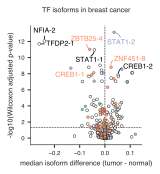

In [158]:
fig = plt.figure(figsize=(2, 2.2))

ax = sns.scatterplot(data=dn_data_exp[dn_data_exp["dn_cat"].isin(["ref"])], 
                     x="med_paired-diff_ratio", y="neglog_padj", 
                     color="white", linewidth=0.5, edgecolor="black", alpha=0.8, zorder=10,
                     **{"s": 8})

sns.scatterplot(data=dn_data_exp[dn_data_exp["dn_cat"].isin(["similar", "rewire", "DN"])], 
                x="med_paired-diff_ratio", y="neglog_padj", 
                hue="dn_cat", palette=dn_pal, linewidth=0.25, edgecolor="black", alpha=0.8, zorder=10,
                **{"s": 8}, ax=ax)

for annot_clone, ha, va, offset, relpos, cs in zip(["STAT1|2/7|03H01", "NFIA|2/5|02G09", 
                                                    "TFDP2|1/4|03C12", "ZBTB25|4/5|04D09", "STAT1|1/7|01B05",
                                                    "ZNF451|8/8|06F02", "CREB1|2/2|01F12", "CREB1|1/2|02E01"],
                                                    ["center", "center", "left", "center", "center", "left",
                                                     "left", "right"],
                                                    ["top", "bottom", "center", "bottom", "top", "bottom",
                                                     "bottom", "center"],
                                                    [(7, -7), (0, 7), (7, 0), (-3, 7), (-5, -7), (3, 5),
                                                     (5, 5), (-7, 0)],
                                                    [(0.5, 1), (0.5, 1), (0, 0.5), (0.5, 0), (0.5, 1), (0, 0.5),
                                                     (0, 0.5), (1, 0.5)],
                                                    ["arc3,rad=0.3", "arc3,rad=0", "arc3,rad=0", "arc3,rad=0.3",
                                                     "arc3,rad=0.3", "arc3,rad=0.3", "arc3,rad=0.3", "arc3,rad=0"]):
    row = dn_data_exp[dn_data_exp["tf1p0_id"] == annot_clone].iloc[0]
    if row["dn_cat"] == "ref":
        color = "black"
    else:
        color = dn_pal[row["dn_cat"]]
    print("annot clone: %s | ha: %s | va: %s" % (annot_clone, ha, va))
    
    shorter_id = annot_clone.split("|")[0] + "-" + annot_clone.split("|")[1].split("/")[0]
    ax.annotate(shorter_id, xy=(row["med_paired-diff_ratio"], row["neglog_padj"]), xytext=offset,
                color=color, ha=ha, va=va,
                textcoords='offset points', bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'),
                arrowprops=dict(arrowstyle="-", color=color, relpos=relpos, connectionstyle=cs))

ax.set_xlabel("median isoform difference (tumor - normal)")
ax.set_ylabel("-log10(Wilcoxon adjusted p-value)")
ax.set_title("TF isoforms in breast cancer\n")

#ax.set_xlim((-0.25, 0.12))
#ax.set_ylim((-0.25, 14))
ax.axhline(y=-np.log10(0.05), linestyle="dashed", color="black", linewidth=0.5)
ax.axvline(x=0, linestyle="dashed", color="black", linewidth=0.5)

ax.get_legend().remove()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig("../../figures/fig7/BRCA_Volcano.pdf", dpi="figure", bbox_inches="tight")

In [159]:
## are DNs enriched within those alt. isos that significantly change in BRCA?

In [160]:
tots = pd.DataFrame(dn_data_exp.dn_cat.value_counts())
sig = pd.DataFrame(dn_data_exp[dn_data_exp["wilcox_padj"] < 0.05].dn_cat.value_counts())
brca_st = tots.join(sig, lsuffix="_tot", rsuffix="_sig")
brca_st = brca_st.loc[["DN", "rewire", "similar", "NA"]]
brca_st = brca_st/brca_st.sum(axis=0)
brca_st

,dn_cat_tot,dn_cat_sig
DN,0.240506,0.312500
rewire,0.111392,0.089286
similar,0.037975,0.035714
NA,0.610127,0.562500


In [161]:
tots.sum()

dn_cat    611
dtype: int64

In [162]:
sig

,dn_cat
ref,78
NA,63
DN,35
rewire,10
similar,4
likely,1


In [163]:
fe = np.zeros((2, 2))

alts = dn_data_exp[dn_data_exp["dn_cat"].isin(["DN", "rewire", "similar", "NA"])]

fe[0, 0] = len(alts[(alts["dn_cat"] == "DN") & 
                    (alts["wilcox_padj"] < 0.05)].tf1p0_id.unique())
fe[1, 0] = len(alts[(alts["dn_cat"] != "DN") & 
                    (alts["wilcox_padj"] < 0.05)].tf1p0_id.unique())
fe[0, 1] = len(alts[(alts["dn_cat"] == "DN") & 
                    (alts["wilcox_padj"] >= 0.05)].tf1p0_id.unique())
fe[1, 1] = len(alts[(alts["dn_cat"] != "DN") & 
                    (alts["wilcox_padj"] >= 0.05)].tf1p0_id.unique())
fe

array([[ 35.,  60.],
       [ 77., 223.]])

In [164]:
print(fisher_exact(fe))
p = fisher_exact(fe)[1]

(1.6893939393939394, 0.03763633649242954)


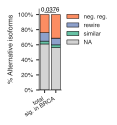

In [165]:
fig, ax = plt.subplots(figsize=(0.4, 1.5))

xs = ["total", "sig. in BRCA"]
y1 = list(brca_st[["dn_cat_tot", "dn_cat_sig"]].loc["NA"])
y2 = list(brca_st[["dn_cat_tot", "dn_cat_sig"]].loc["similar"])
b2 = np.add(y1, y2)
y3 = list(brca_st[["dn_cat_tot", "dn_cat_sig"]].loc["rewire"])
b3 = np.add(b2, y3)
y4 = list(brca_st[["dn_cat_tot", "dn_cat_sig"]].loc["DN"])

ax.bar(xs, y1, color=dn_pal["NA"], label="NA", edgecolor="black", linewidth=0.5)
ax.bar(xs, y2, bottom=y1, color=dn_pal["similar"], label="similar", edgecolor="black", linewidth=0.5)
ax.bar(xs, y3, bottom=b2, color=dn_pal["rewire"], label="rewire", edgecolor="black", linewidth=0.5)
ax.bar(xs, y4, bottom=b3, color=dn_pal["DN"], label="neg. reg.", edgecolor="black", linewidth=0.5)

# annotate pval
annotate_pval(ax, 0, 1, 1.025, 0, 1.025, p, fontsize-1)

# add legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1.01, 1), frameon=False)

ax.set_ylabel("% Alternative isoforms")
ax.set_xticklabels(xs, rotation=30, ha="right", va="top")
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(["%s%%" % x for x in [0, 20, 40, 60, 80, 100]])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig("../../figures/fig7/dn_stacked_bar_brca.pdf", dpi="figure", bbox_inches="tight")

### CREB1 vignette

In [166]:
brca_isos = brca_isos.merge(tf_id_map[["iso_id", "gene_name"]], on="iso_id").drop_duplicates()
len(brca_isos)

1197

In [167]:
brca_isos_paired = brca_isos[["gene_name", "iso_id"] + tcga_paired_ctrls + tcga_paired_tumors]
new_ctrl_cols = ["normal - %s" % (i+1) for i, x in enumerate(tcga_paired_ctrls)]
new_tumor_cols = ["tumor - %s" % (i+1) for i, x in enumerate(tcga_paired_tumors)]
brca_isos_paired.columns = ["gene_name", "iso_id"] + new_ctrl_cols + new_tumor_cols

In [168]:
def brca_expression_plot(gene_name, figsize, ylim, df, cols, fig_suffix, ctrls_line, tumor_line):
    df_sub = df[df["gene_name"] == gene_name]
    df_sub.set_index("iso_id", inplace=True)
    df_sub = df_sub[cols].drop_duplicates()
    #print(df_sub.head())
    n_isos = len(df_sub)
    palette = sns.color_palette("husl", as_cmap=False, n_colors=n_isos)
    fig, axes = plt.subplots(2, 1, sharex=True)
    fig.set_size_inches(figsize)
    ### bar chart ###
    (df_sub
          .T
          .plot.bar(ax=axes[0],
                    legend=False,
                    width=0.7,
                    color=list(palette)))
    ### percentages ###
    (df_sub.div(df_sub.sum(axis=0))
              .T.plot.bar(ax=axes[1], 
                          stacked=True,
                          legend=False,
                          color=list(palette)))
    axes[0].set_yscale("symlog")
    axes[0].set_ylabel('tpm')
    #axes[0].set_ylim(ylim)
    axes[1].set_ylabel('percent')
    axes[1].set_yticklabels(['{:.0%}'.format(t) for t in axes[1].get_yticks()])
    axes[1].legend(loc='lower left', bbox_to_anchor=(1, 0))
    axes[0].axhline(y=1, color='black', linewidth=0.5, linestyle="dashed")
    
    # add medians
    axes[1].plot(ctrls_line[0], ctrls_line[1], color="black", linewidth=0.5, linestyle="dashed")
    axes[1].plot(tumor_line[0], tumor_line[1], color="black", linewidth=0.5, linestyle="dashed")
    
    axes[0].spines['right'].set_visible(False)
    axes[0].spines['top'].set_visible(False)
    axes[1].spines['right'].set_visible(False)
    axes[1].spines['top'].set_visible(False)
    
    plt.subplots_adjust(hspace=0.15)
    plt.savefig('../../figures/fig7/brca_' + gene_name + '_' + fig_suffix + '.pdf',
                bbox_inches='tight')

In [169]:
creb1 = dn_data_exp[dn_data_exp["gene_name"] == "CREB1"][["gene_name", "tf1p0_id", "dn_cat", "med_paired-brca_ratio",
                                                          "med_paired-ctrls_ratio", "med_paired-diff_ratio"]]
creb1

,gene_name,tf1p0_id,dn_cat,med_paired-brca_ratio,med_paired-ctrls_ratio,med_paired-diff_ratio
54,CREB1,CREB1|2/2|01F12,ref,0.251397,0.197691,0.052646
56,CREB1,CREB1|1/2|02E01,DN,0.748603,0.802309,-0.052646


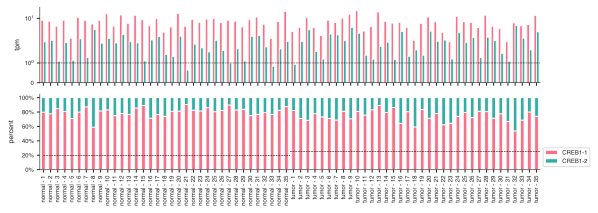

In [170]:
cols = new_ctrl_cols[0:35] + new_tumor_cols[0:35]
brca_expression_plot("CREB1", (9, 3), (0, 6), brca_isos_paired, cols, "paired",
                     ([0, 34.5], [creb1[creb1["dn_cat"] == "ref"]["med_paired-ctrls_ratio"].iloc[0], 
                                  creb1[creb1["dn_cat"] == "ref"]["med_paired-ctrls_ratio"].iloc[0]]), 
                     ([34.5, 70], [creb1[creb1["dn_cat"] == "ref"]["med_paired-brca_ratio"].iloc[0], 
                                   creb1[creb1["dn_cat"] == "ref"]["med_paired-brca_ratio"].iloc[0]]))

In [171]:
f_brca_paired = f_brca_filt[["gene_name", "iso_id"] + tcga_paired_ctrls + tcga_paired_tumors]
new_ctrl_cols = ["normal - %s" % (i+1) for i, x in enumerate(tcga_paired_ctrls)]
new_tumor_cols = ["tumor - %s" % (i+1) for i, x in enumerate(tcga_paired_tumors)]
f_brca_paired.columns = ["gene_name", "iso_id"] + new_ctrl_cols + new_tumor_cols

In [172]:
f_brca_paired_melt = pd.melt(f_brca_paired, id_vars=["gene_name", "iso_id"])
f_brca_paired_melt["samp"] = f_brca_paired_melt["variable"].str.split(" ", expand=True)[0]

In [173]:
dn_data_exp = dn_data_exp.merge(tf_id_map[["gene_name", "clone_acc", "iso_id", "merge_id"]], 
                                left_on=["gene_name", "tf1p0_id"],
                                right_on=["gene_name", "clone_acc"]).drop_duplicates(subset="tf1p0_id")
print(len(dn_data_exp))

611


CREB1-1
1.4661907437171488e-08
CREB1-2
1.4661907437171488e-08


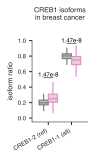

In [174]:
tmp = f_brca_paired_melt[f_brca_paired_melt["gene_name"] == "CREB1"]

fig = plt.figure(figsize=(1, 1.5))

ax = sns.boxplot(data=tmp, x="iso_id", y="value", hue="samp", fliersize=0,
                 palette={"normal": "gray", "tumor": sns.color_palette("Set2")[3]},
                 order=["CREB1-2", "CREB1-1"])
mimic_r_boxplot(ax)

# sns.swarmplot(data=tmp, x="iso_id", y="value", hue="samp",
#               palette={"normal": "gray", "tumor": sns.color_palette("Set2")[3]}, ax=ax,
#               size=1, edgecolor="black", linewidth=0.5, alpha=0.5, split=True,
#               order=["CREB1-2", "CREB1-1"])

# annotate w p-vals
ys = [0.52, 0.96]
for i, iso in enumerate(tmp.iso_id.unique()):
    print(iso)
    padj = dn_data_exp[dn_data_exp["iso_id"]==iso]["wilcox_padj"].iloc[0]
    print(padj)
    annotate_pval(ax, i-0.2, i+0.2, ys[i], 0, ys[i], padj, fontsize-1)

ax.set_xlabel("")
ax.set_xticklabels(["CREB1-2 (ref)", "CREB1-1 (alt)"], rotation=30, va="top", ha="right")
ax.set_ylabel("isoform ratio")
ax.set_title("CREB1 isoforms\nin breast cancer\n\n")
ax.get_legend().remove()
ax.set_ylim((-0.05, 1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig("../../figures/fig7/BRCA_CREB1_boxplot.pdf", dpi="figure", bbox_inches="tight")

1.4661907437171488e-08


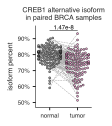

In [175]:
fig = plt.figure(figsize=(1, 1.5))

# plot alt isoform only
alt = tmp[tmp["iso_id"] == "CREB1-1"]

ax = sns.swarmplot(data=alt, x="samp", y="value", s=2,
                   palette={"normal": "gray", "tumor": sns.color_palette("Set2")[3]},
                   alpha=0.75, linewidth=0.5, edgecolor="black",
                   order=["normal", "tumor"])

norm_paths = ax.collections[0].get_offsets()
norm_x, norm_y = norm_paths[:, 0], norm_paths[:, 1]

tumor_paths = ax.collections[1].get_offsets()
tumor_x, tumor_y = tumor_paths[:, 0], tumor_paths[:, 1]

# argsort so that points correspond to each other
norm_vals = list(alt[alt["samp"] == "normal"]["value"])
norm_idxs = np.argsort(norm_vals)
tumor_vals = list(alt[alt["samp"] == "tumor"]["value"])
tumor_idxs = np.argsort(tumor_vals)
tumor_x_sorted = tumor_x[tumor_idxs.argsort()][norm_idxs]
tumor_y_sorted = tumor_y[tumor_idxs.argsort()][norm_idxs]

for i in range(norm_x.shape[0]):
    x = [norm_x[i], tumor_x_sorted[i]]
    y = [norm_y[i], tumor_y_sorted[i]]
    
    ax.plot(x, y, linestyle="dashed", color="darkgrey", linewidth=0.5)

# annotate w p-vals
padj = dn_data_exp[dn_data_exp["iso_id"]== "CREB1-1"]["wilcox_padj"].iloc[0]
print(padj)
annotate_pval(ax, 0, 1, 0.95, 0, 0.95, padj, fontsize-1)

ax.set_xlabel("")
ax.set_ylim((0.47, 0.98))
ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9])
ax.set_yticklabels("%s%%" % x for x in [50, 60, 70, 80, 90])
ax.set_ylabel("isoform percent")
ax.set_title("CREB1 alternative isoform\nin paired BRCA samples")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig("../../figures/fig7/BRCA_CREB1_swarmplot_paired.pdf", dpi="figure", bbox_inches="tight")

83
29
112


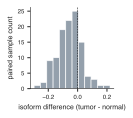

In [176]:
creb1_iso_diff = f_brca_filt[f_brca_filt["iso_id"] == "CREB1-1"][paired_ratio_cols]
creb1_iso_diff = pd.melt(creb1_iso_diff)
creb1_iso_diff = creb1_iso_diff[~pd.isnull(creb1_iso_diff["value"])]

fig = plt.figure(figsize=(1.5, 1.5))
ax = sns.histplot(data=creb1_iso_diff, x="value", color="slategrey")
ax.axvline(x=0, linestyle="dashed", color="black", linewidth=0.5)
ax.set_xlabel("isoform difference (tumor - normal)")
ax.set_ylabel("paired sample count")

print(len(creb1_iso_diff[creb1_iso_diff["value"] < 0]))
print(len(creb1_iso_diff[creb1_iso_diff["value"] > 0]))
print(len(creb1_iso_diff))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig("../../figures/fig7/BRCA_CREB1_iso_diff_hist.pdf", dpi="figure", bbox_inches="tight")

In [177]:
for i, row in tcga_paired.iterrows():
    brca_gene_sum["paired-diff_%s" % (i+1)] = brca_gene_sum[row.tcga_id_tumor]-brca_gene_sum[row.tcga_id_ctrl]

In [178]:
len(tcga_paired)

112

In [179]:
len(tcga_paired.tcga_id_tumor.unique())

112

In [180]:
paired_diff_cols = [x for x in brca_gene_sum.columns if "paired-diff_" in x]
len(paired_diff_cols)

112

In [181]:
brca_genes_paired = brca_gene_sum[tcga_paired_ctrls + tcga_paired_tumors]
new_ctrl_cols = ["normal - %s" % (i+1) for i, x in enumerate(tcga_paired_ctrls)]
new_tumor_cols = ["tumor - %s" % (i+1) for i, x in enumerate(tcga_paired_tumors)]
brca_genes_paired.reset_index(inplace=True)
print(len(brca_genes_paired))

brca_genes_paired = brca_genes_paired.merge(tf_id_map[["iso_id", "gene_name"]], on="iso_id")
print(len(brca_genes_paired.gene_name.unique()))
brca_genes_paired.drop("iso_id", axis=1, inplace=True)
brca_genes_paired.drop_duplicates(inplace=True)
print(len(brca_genes_paired))

brca_genes_paired.columns = new_ctrl_cols + new_tumor_cols + ["gene_name"]
brca_genes_paired = brca_genes_paired[["gene_name"] + new_ctrl_cols + new_tumor_cols]
brca_genes_paired.head()

1197
246
246


,gene_name,normal - 1,normal - 2,normal - 3,normal - 4,normal - 5,normal - 6,normal - 7,normal - 8,normal - 9,...,tumor - 103,tumor - 104,tumor - 105,tumor - 106,tumor - 107,tumor - 108,tumor - 109,tumor - 110,tumor - 111,tumor - 112
0,AEBP2,22.747116,25.360059,13.053132,21.689286,5.037457,18.746277,13.438177,21.562010,18.254118,...,6.820301,8.266360,9.485268,11.119940,7.979728,21.733489,16.502465,25.708199,24.231209,12.264990
6,ARNT2,8.990080,2.144570,0.633732,5.993860,0.913770,0.679537,0.509112,1.838544,6.967930,...,1.675940,13.695280,2.204120,9.299280,8.513605,17.902066,37.339094,19.063620,45.678413,4.577970
11,ARNTL,8.878580,8.248831,2.383311,7.282717,2.082343,3.933337,2.122712,5.940556,10.486570,...,9.205770,4.637577,4.162877,7.260050,4.573066,4.085098,1.415313,12.662270,9.619746,4.138104
16,ARNTL2,1.720048,1.912761,1.749956,3.025926,1.135368,2.928059,3.590936,1.663023,5.605723,...,3.320597,2.546525,4.135825,0.960335,0.899804,1.037009,4.028218,20.040315,1.918131,1.508104
26,ATF2,16.994638,15.618396,14.177667,19.076537,7.618544,20.036020,18.920196,16.274765,17.225320,...,10.498892,12.909628,14.001542,13.230331,10.542760,13.528642,12.314017,24.043076,27.137789,18.463038


In [182]:
brca_genes_paired["wilcox_pval"] = brca_genes_paired.apply(paired_pval, ctrl_cols=new_ctrl_cols, tumor_cols=new_tumor_cols, axis=1)
brca_genes_paired["wilcox_n_samps"] = brca_genes_paired.apply(paired_samps, ctrl_cols=new_ctrl_cols, tumor_cols=new_tumor_cols, axis=1)
print(len(brca_genes_paired))

brca_genes_paired_filt = brca_genes_paired[(~pd.isnull(brca_genes_paired["wilcox_pval"])) & (brca_genes_paired["wilcox_n_samps"] >= 10)]
print(len(brca_genes_paired_filt))

brca_genes_paired_filt["wilcox_padj"] = smt.multipletests(list(brca_genes_paired_filt["wilcox_pval"]), alpha=0.05, method="fdr_bh")[1]

246
246


In [183]:
brca_genes_paired_melt = pd.melt(brca_genes_paired_filt, id_vars=["gene_name"])
brca_genes_paired_melt["samp"] = brca_genes_paired_melt["variable"].str.split(" ", expand=True)[0]

0.9814707801011389


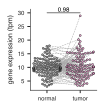

In [184]:
fig = plt.figure(figsize=(1.2, 1.5))

# plot alt isoform only
creb1 = brca_genes_paired_melt[brca_genes_paired_melt["gene_name"] == "CREB1"]

ax = sns.swarmplot(data=creb1, x="samp", y="value", s=2,
                   palette={"normal": "gray", "tumor": sns.color_palette("Set2")[3]},
                   alpha=0.75, linewidth=0.5, edgecolor="black",
                   order=["normal", "tumor"])

norm_paths = ax.collections[0].get_offsets()
norm_x, norm_y = norm_paths[:, 0], norm_paths[:, 1]

tumor_paths = ax.collections[1].get_offsets()
tumor_x, tumor_y = tumor_paths[:, 0], tumor_paths[:, 1]

# argsort so that points correspond to each other
norm_vals = list(creb1[creb1["samp"] == "normal"]["value"])
norm_idxs = np.argsort(norm_vals)
tumor_vals = list(creb1[creb1["samp"] == "tumor"]["value"])
tumor_idxs = np.argsort(tumor_vals)
tumor_x_sorted = tumor_x[tumor_idxs.argsort()][norm_idxs]
tumor_y_sorted = tumor_y[tumor_idxs.argsort()][norm_idxs]

for i in range(norm_x.shape[0]):
    x = [norm_x[i], tumor_x_sorted[i]]
    y = [norm_y[i], tumor_y_sorted[i]]
    ax.plot(x, y, linestyle="dashed", color="darkgrey", linewidth=0.5)

# annotate w p-vals
padj = brca_genes_paired_filt[brca_genes_paired_filt["gene_name"]== "CREB1"]["wilcox_padj"].iloc[0]
print(padj)
annotate_pval(ax, 0, 1, 30, 0, 30, padj, fontsize-1)

ax.set_xlabel("")
ax.set_ylabel("gene expression (tpm)")
#ax.set_title("CREB1 alternative isoform\nin paired BRCA samples")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig("../../figures/fig7/BRCA_CREB1_gene_expression_swarmplot_paired.pdf", dpi="figure", bbox_inches="tight")

In [185]:
i = 0
for tumor, normal in zip(new_tumor_cols, new_ctrl_cols):
    brca_genes_paired_filt["paired-diff_%s" % (i+1)] = brca_genes_paired_filt[tumor]-brca_genes_paired_filt[normal]
    i += 1

paired_diff_cols = [x for x in brca_genes_paired_filt.columns if "paired-diff_" in x]

60
52
112


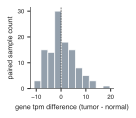

In [186]:
creb1_gene_diff = brca_genes_paired_filt[brca_genes_paired_filt["gene_name"] == "CREB1"][paired_diff_cols]
creb1_gene_diff = pd.melt(creb1_gene_diff)

fig = plt.figure(figsize=(1.5, 1.5))
ax = sns.histplot(data=creb1_gene_diff, x="value", color="slategrey")
ax.axvline(x=0, linestyle="dashed", color="black", linewidth=0.5)
ax.set_xlabel("gene tpm difference (tumor - normal)")
ax.set_ylabel("paired sample count")

print(len(creb1_gene_diff[creb1_gene_diff["value"] < 0]))
print(len(creb1_gene_diff[creb1_gene_diff["value"] > 0]))
print(len(creb1_gene_diff))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig("../../figures/fig7/BRCA_CREB1_gene_diff_hist.pdf", dpi="figure", bbox_inches="tight")

In [187]:
from plotting import (y2h_ppi_per_tf_gene_plot,
                      y1h_pdi_per_tf_gene_plot,
                      m1h_activation_per_tf_gene_plot)

from data_loading import (load_y2h_isoform_data,
                          load_m1h_activation_data,
                          load_y1h_pdi_data)

In [188]:
y2h = load_y2h_isoform_data()
m1h = load_m1h_activation_data(add_missing_data=True)
y1h = load_y1h_pdi_data()

In [189]:
gene_name = "CREB1"

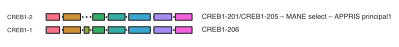

In [190]:
fig, ax = plt.subplots(figsize=(3, 0.6))

tfs[gene_name].exon_diagram(ax=ax, )
fig.savefig("../../figures/fig7/{}_exon_diagram.pdf".format(gene_name), bbox_inches="tight", dpi="figure")

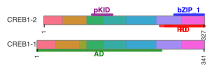

In [191]:
fig, ax = plt.subplots(figsize=(3, 0.6))

tfs[gene_name].protein_diagram(only_cloned_isoforms=True, draw_legend=False, ax=ax)
fig.savefig("../../figures/fig7/{}_protein_diagram.pdf".format(gene_name), bbox_inches="tight", dpi="figure")

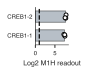

In [192]:
fig, ax = plt.subplots(1, 1, figsize=(0.6, 0.7))

df = m1h_activation_per_tf_gene_plot(gene_name, data=m1h, ax=ax, iso_order=["CREB1-2", "CREB1-1"], xlim=(0, 8.5))
plt.savefig('../../figures/fig7/{}_m1h-profile.pdf'.format(gene_name), bbox_inches='tight')

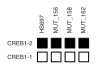

In [193]:
tf = tfs[gene_name]
fig, ax = plt.subplots(1, 1, figsize=(1, 1))
y1h_pdi_per_tf_gene_plot(tf.name, ax=ax, data=y1h, iso_order=["CREB1-2", "CREB1-1"])
plt.savefig('../../figures/fig7/{}_y1h-profile.pdf'.format(gene_name), bbox_inches='tight')

In [194]:
def developmental_tissue_expression_plot(gene_name, palette_name, figsize, ylim, means, cols, fig_suffix, shorten_x=False):
    n_isos = len(means.loc[genes == gene_name])
    palette = sns.color_palette(palette_name, as_cmap=False, n_colors=n_isos)
    fig, axes = plt.subplots(2, 1, sharex=True)
    fig.set_size_inches(figsize)
    ### bar chart ###
    (means.loc[genes == gene_name, cols]
          .T
          .plot.bar(ax=axes[0],
                    legend=False,
                    width=0.7,
                    color=list(palette)))
    ### percentages ###
    raw_means = 2 ** means.loc[genes == gene_name, cols] - 1.
    (raw_means.div(raw_means.sum(axis=0))
              .T.plot.bar(ax=axes[1], 
                          stacked=True,
                          legend=False,
                          color=list(palette)))
    
    if shorten_x:
        xticks = list(axes[1].get_xticklabels())
        xticks_short = [x.get_text().split("-")[0].strip() for x in xticks]
        axes[1].set_xticklabels(xticks_short, rotation=90, va="top", ha="center")
        
    axes[0].set_ylabel('log2(tpm + 1)\n')
    axes[0].set_ylim(ylim)
    axes[1].set_ylabel('percent')
    axes[1].set_yticklabels(['{:.0%}'.format(t) for t in axes[1].get_yticks()])
    axes[1].legend(loc='lower left', bbox_to_anchor=(1, 0), frameon=False)
    axes[0].axhline(y=1, color='black', linewidth=0.5, linestyle="dashed")
    
    for spine in ['right', 'top']:
        axes[0].spines[spine].set_visible(False)
        axes[1].spines[spine].set_visible(False)
    
    plt.subplots_adjust(hspace=0.25)
    plt.savefig('../../figures/fig7/expression_' + gene_name + '_' + fig_suffix + '.pdf',
                bbox_inches='tight')

In [195]:
if not (genes_gtex == genes_dev).all():
        raise UserWarning()
genes = genes_gtex

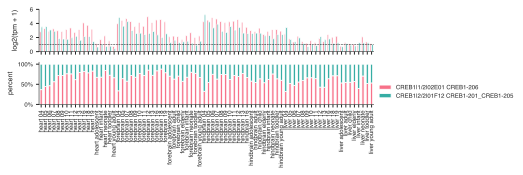

In [196]:
heart_cols = [x for x in means_dev.columns if "heart" in x]
brain_cols = [x for x in means_dev.columns if "brain" in x]
liver_cols = [x for x in means_dev.columns if "liver" in x]
developmental_tissue_expression_plot("CREB1", "husl", (6, 1.75), (0, 6), means_dev, 
                                     heart_cols + brain_cols + liver_cols, 
                                     "means_dev_heart_brain_liver")

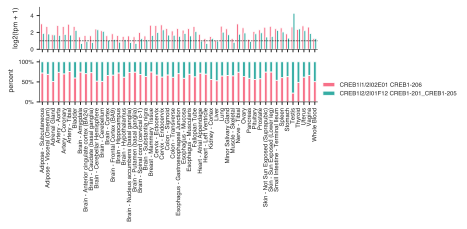

In [197]:
developmental_tissue_expression_plot("CREB1", "husl", (5, 1.75), (0, 5), means_gtex, 
                                     means_gtex.columns, 
                                     "means_gtex_all")

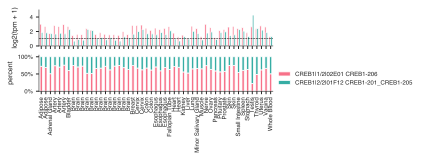

In [198]:
developmental_tissue_expression_plot("CREB1", "husl", (4.2, 1.5), (0, 5), means_gtex, 
                                     means_gtex.columns, 
                                     "means_gtex_all_short", shorten_x=True)

## 13. make supplemental tables

In [199]:
# first supp table: DN classifications
supp_negregs = pairs[["gene_symbol", "Ensembl_gene_ID", "family", "ref_iso",
                      "alt_iso", "dbd_pct_lost", "m1h_cat", "y1h_cat", "y2h_cat", "loc_cat", "dn_cat", "dn_short"]]
supp_negregs.dn_short.value_counts()

NA         273
DN         103
rewire      54
similar     15
likely       1
Name: dn_short, dtype: int64

In [200]:
supp_negregs.columns = ["gene_symbol", "Ensembl_gene_ID", "family", "reference_isoform",
                        "alternative_isoform", "DBD_pct_lost_in_alt",
                        "M1H_activation_category", "PDI_category", "PPI_category", "localization_category",
                        "detailed_alt_iso_classification",
                        "alt_iso_classification"]
supp_negregs = supp_negregs[["gene_symbol", "Ensembl_gene_ID", "family", "reference_isoform",
                             "alternative_isoform", "DBD_pct_lost_in_alt",
                             "PDI_category", "PPI_category", "M1H_activation_category", "localization_category",
                             "alt_iso_classification", "detailed_alt_iso_classification"]]

supp_negregs["alt_iso_classification"].replace("DN", "negative regulator", inplace=True)
supp_negregs["detailed_alt_iso_classification"] = supp_negregs["detailed_alt_iso_classification"].str.replace("DN", "negative regulator")

supp_negregs["alt_iso_classification"].replace("rewire", "rewirer", inplace=True)
supp_negregs["detailed_alt_iso_classification"].replace("rewire", "rewirer", inplace=True)

supp_negregs["alt_iso_classification"].replace("similar", "similar to ref.", inplace=True)
supp_negregs["detailed_alt_iso_classification"].replace("similar", "similar to ref.", inplace=True)

supp_negregs["alt_iso_classification"].replace("likely", "likely non-functional", inplace=True)
supp_negregs["detailed_alt_iso_classification"].replace("likely", "likely non-functional", inplace=True)

supp_negregs[supp_negregs["alt_iso_classification"] == "negative regulator"].sample(5)

,gene_symbol,Ensembl_gene_ID,family,reference_isoform,alternative_isoform,DBD_pct_lost_in_alt,PDI_category,PPI_category,M1H_activation_category,localization_category,alt_iso_classification,detailed_alt_iso_classification
215,ESRRA,ENSG00000173153,Nuclear receptor,ESRRA-1,ESRRA-2,95.714286,NA,PPI rewire,similar,NA,negative regulator,negative regulator (DBD loss)
225,ZBTB44,ENSG00000196323,C2H2 ZF,ZBTB44-1,ZBTB44-3,53.982301,NA,PPI rewire,repression GoF,no localization change,negative regulator,negative regulator (DBD loss)
127,E2F3,ENSG00000112242,E2F,E2F3-2,E2F3-4,100.000000,PDI loss,PPI loss: all,rewire,NA,negative regulator,"negative regulator (PDIs,PPIs,DBD loss)"
49,ATF2,ENSG00000115966,bZIP,ATF2-1,ATF2-5,100.000000,NA,PPI loss: dimer,activation GoF,no localization change,negative regulator,"negative regulator (PPIs,DBD loss)"
125,ZNF451,ENSG00000112200,C2H2 ZF,ZNF451-2,ZNF451-8,NaN,NA,PPI loss: all,rewire,NA,negative regulator,negative regulator (PPIs)


In [201]:
supp_negregs.alt_iso_classification.value_counts()

NA                       273
negative regulator       103
rewirer                   54
similar to ref.           15
likely non-functional      1
Name: alt_iso_classification, dtype: int64

In [202]:
supp_negregs.to_csv("../../supp/SuppTable_NegRegs.txt", sep="\t", index=False)

In [203]:
# second supp table: BRCA samples used in TCGA analysis
supp_brcasamps = tcga_paired[["tcga_id_ctrl", "tcga_id_tumor"]]
len(supp_brcasamps)

112

In [204]:
supp_brcasamps.to_csv("../../supp/SuppTable_BRCASamps.txt", sep="\t", index=False)

In [205]:
# third supp table: BRCA results for isos
[x for x in list(f_brca_filt.columns) if not x.startswith("TCGA") and not x.startswith("paired")]

['iso_id',
 'med_paired-brca_ratio',
 'med_paired-ctrls_ratio',
 'wilcox_pval',
 'wilcox_n_samps',
 'wilcox_padj',
 'med_paired-diff_ratio',
 'gene_name',
 'clone_acc',
 'enst_id',
 'merge_id']

In [206]:
supp_brcares = f_brca_filt[["gene_name", "iso_id", "med_paired-brca_ratio", "med_paired-ctrls_ratio",
                            "med_paired-diff_ratio", "wilcox_pval", "wilcox_n_samps", "wilcox_padj"]]
supp_brcares.columns = ["gene_symbol", "isoform", "median_tumor_iso_pct", "median_normal_iso_pct",
                        "median_iso_pct_difference", "pval", "n_samps", "padj"]
print(len(supp_brcares))
supp_brcares.head()

1299


,gene_symbol,isoform,median_tumor_iso_pct,median_normal_iso_pct,median_iso_pct_difference,pval,n_samps,padj
0,AEBP2,AEBP2-2,0.073206,0.070899,0.006112,0.570810,112,0.738572
1,AEBP2,AEBP2-201,0.198051,0.199620,0.005161,0.703716,112,0.840813
2,AEBP2,AEBP2-202,0.362672,0.328408,0.025583,0.086208,112,0.201026
3,AEBP2,AEBP2-204,0.000000,0.000000,0.000000,0.888314,112,0.941142
4,AEBP2,AEBP2-207,0.325916,0.357091,-0.031170,0.110328,112,0.235965


In [207]:
supp_brcares.to_csv("../../supp/SuppTable_BRCAResults.txt", sep="\t", index=False)